<h1 style="letter-spacing:0px;">Skin Fork</h1>

Esse é o nome-codigo de um engine criado utilizando o Ursina.

O Ursina é uma camada de abstração em Python que executa em cima do Panda3D e simplifica bastante o trabalho.

O desenvolvimento será em Python e nao será embutido em notebooks, mas documentarei partes relevantes. No entanto, vou utilizar outros notebooks pra isso.

Neste pretendo colocar ferramentas para o engine em si.

Inicialmente, duas: o Editor SVG para desenhar cidades, e um criador de imagens para Sky Spheres.


<h1 style="letter-spacing: 0px">TODO: Edição de Imagem para Sky Sphere</h1>

Para criar imagens que possam ser mapeadas na Sky Sphere do Ursina, é preciso:

Como a intenção é desenvolver um sistema capaz de blitar nas imagens de Sky Sphere o terreno (dessa forma terrenos muito grandes, de mais do q 16Km de lado, podem ser construidos e depois de impressos na Sky Sphere destruidos e nao mais renderizados), pretendo utilizar a mesma técnica para transformar imagens comuns em Sky Spheres. 

Para isso é preciso substituir a atual Sky Sphere do Ursina pela esfera criada pela projeção de um cubo numa esfera, que estou usando para criar o planeta em que o engine atua.

A idéia é que a imagem seja dividida ao meio no sentido da esquerda para a direita e em 3 partes no sentido de baixo para cima.

as duas divisoes centrais no sentido de baixo pra cima serão então mapeadas em 2 faces verticais do cubo, e espelhada nas duas outras (isso cria uma imagem sem costuras no horizonte, mas repete os elementos, então se a imagem tiver elementos muito carateristicos no horizonte - uma pedra, uma arvore, um edificio) a repetição vai ser notada.

Ja na face superior do cubo será preciso usar um dos triangulos que compoe a face para mapear as duas partes de cima da imagem, e espelha-las no outro triangulo. Se isso causar muita distorção, pode-se fazer com qu as divisoes superiores tenham menos pixels na vertical do que as divisões centrais. Note que, se tivermos o Sol na imagem e ele nao estiver exatamente acima no meio (e ainda assim ele deve ser cortado no meio) teremos dois Sóis :) no céu.

O mesmo deve ser feito na face inferior com as divisoes inferiores com as mesmas observações sobre features muito distintas.

Feito isso projeta-se o cubo na esfera e temos uma SkySphere razoavel (espero) feita com quase qualquer imagem comum.

<h1>Simulações para o sistema de Terrenos</h1>

O sistema de terreno funciona baseado em LODs. O LOD 8 é chamado de divisão no planeta. O cubo que é projetado numa esfera tem 28 divisoes por face, o que cria 112 divisoes ao longo do que se tornará o equador da quad-esfera.

Cada uma dessas facetas representará uma área de 354.294m, o que faz com que o planeta tenha 39K68 kms de circunferencia,o que é próximo do tamanho da Terra. Os LODs seguem a seguinte progressão:

5 - 354Km - divisao do planeta

4 - Chamado de "territorio"

118Km (118.098m) - uma divisao por 3 do superior, e isso é feito pq a distancia para
     cadeias de montanhas altas como o Everest pode ser vista a 120Km de distancia. Este nível será então plotado em arco
     acompanhando a curvatura do planeta, e plotado na SkySphere, depois nao será mais plotado a nao ser que o player
     se desloque o suficiente (muitos Kms de distancia, provavelmente 19K)
     
3 - Chamado de "Ambito"

19.683m - a partir deste nivel os niveis abaixo sao divisoes por 9 dos acima. Este nivel é o que vai de um horizonte a outro (de fato é um pouco maior, 16Km seria suficiente). 

2 - Chamado de "Localidade"

2187m - O engine tem o conceito de "localidades" que não são equivalentes a este conceito: aqui trata-se somente do nome dado a divisoes por 9 do ambito.

1 - Local distante (local far) - 243m

0 - Local - 27m


O planeta é gerado com ruido Perlin, continuo numa projeção esférica na qual se usam como valores as posicoes X,Y e Z dos vertices do cubo, ja projetados na esfera. Isso garante continuidade (o planeta nao tem costuras) mas com ausencia de repeticoes (cada feature no planeta é unica).

Os LODs devem ser recriados somente quando necessarios. Um algoritmo de invalidação faz com que determinados mapas em
cada um desses LODs seja desenhado quando o player se move. 

**TODO: ainda nao estou certo do texto abaixo, posso talvez somente calcular diretamente a altura usando o Perlin e subdividindo o espaço mesmo (fornecendo vertices a 354Km de distancia no 5, 118 no 4, e assim por diante )**

A ideia dos LODs é então nao modificar radicalmente as features do terreno. Para isso, o nivel 5 nao deve modificar nem a posicao dos 4 pontos vertices no nivel 4 que o define, nem fazer com que a altura média no nivel 4 seja radicalmente modificada.

Atualmente a tecnica utilizada é gerar ruido Perlin numa matriz e interpretar o valor como uma variacao de altura menor do q na do LOD anterior, a saber:

8 - variação é normalizada para o intervalo de -0.86 a 0.86, e multiplicada por 10.000 representa metros de altitude ou profundidade.

7 - Este nivel é gerado somando-se à interpolação das alturas o dobro do valor da interferencia do nivel 6, ou seja, 1458m. No entanto os valores do ruido são multiplicados por 10 e elevados ao quadrado para tornar locais altos mais raros (no entanto valores negativos são mantidos negativos, entao nao verdade temos n * abs(n), nao exatamente o quadrado).

6 - Neste nivel considera-se a variação como um terço do tamanho do LOD abaixo, ou seja, +/- 729m

5 - => A partir deste nivel considera-se a variação como 1/9 do tamanho do nivel, +/- 243m

4 => += 27m

3 => += 3m

2 => += neste nivel a variação é de +/- 1m

1 => neste nivel a variação é de +/- um 27 avos do tamanho do nivel, ou seja, +/- 11cm

Abaixo encontram-se simulações do procedimento, utilizadas para ajuste do algoritmo.

In [1]:
!pip install perlin-noise
#!pip install matplotlib

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:568: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.


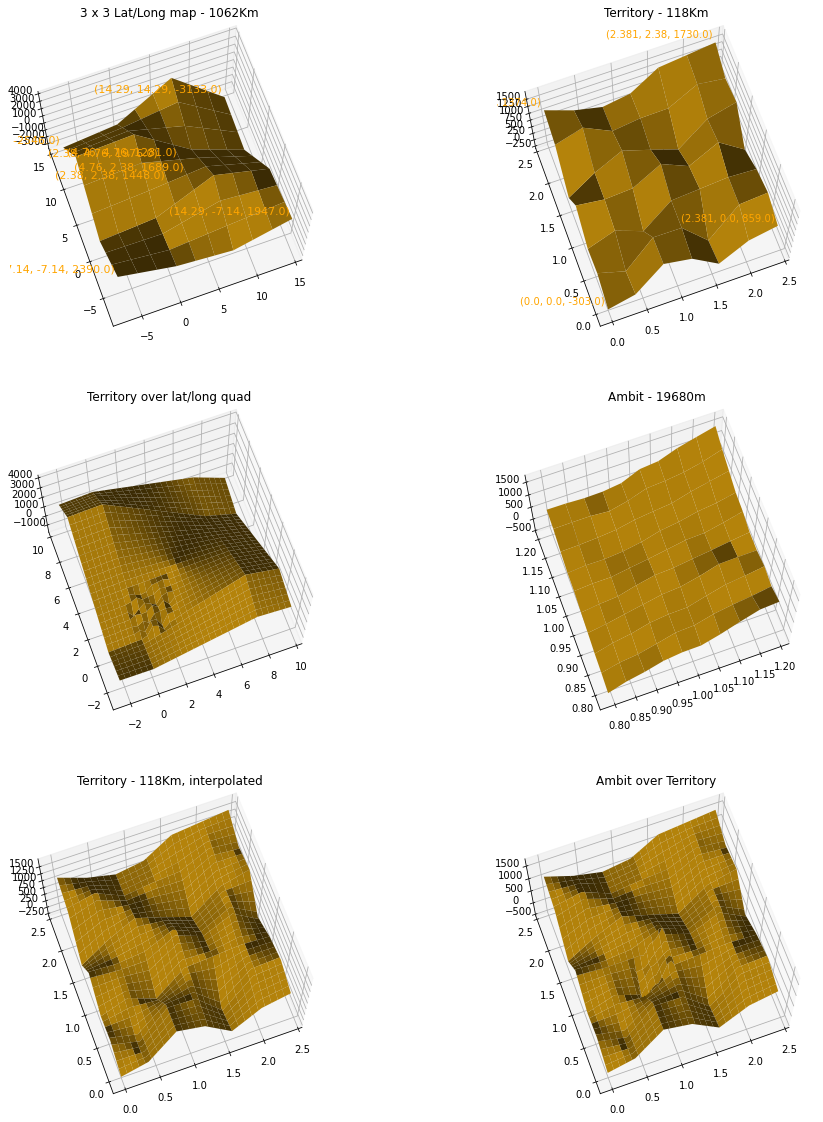

In [23]:
from perlin_noise import PerlinNoise
from math import sqrt
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np

%matplotlib inline


class SForkTerrain():
    def __init__( self ):
        self.__divs = 28
        
        # heightmap keeps level max (lod 5, latLong quad) - there is no other representation of 
        # this level in the engine
        self.heightmap = [ float( "-inf" ) for i in range(( self.__divs + 1 )**2 * 6 )]
        
        # noise convolution
        self.__conv = 4

        # TODO: allow planet seed to be informed (it will be the seed of the perlin)
        self.__noise = [ PerlinNoise( octaves = 2 * 2 ** i, seed = 1 ) for i in range( self.__conv )]
        
        self.__noise_power = 1.5
    
        # lat/long are centered in the center of each planet face
        self.__lat = 0
        self.__long = 0
        self.__face = "a"  #(Ahead)

        # vertices and heigths of the terrain maps
        self.__levelsv = [ None for i in range( 5 )]
        self.__levelsh = [ None for i in range( 5 )]

        # size in m of the side of each lod (in lod0 to 4 order)
        self.__sizes = [ 27., 243., 2187., 19683., 118098. ]

        self.__faces = { "a": 0, "ahead": 0, "s": 5, "south": 5, "b": 2, "back": 2, "behind": 2,
                         "n": 4, "north": 4, "w": 3, "west": 3, "e": 1, "east": 1 }

        # relative positions of a lod inside the parent ones (in lod0 to 4 order)
        self.__relatives = [( 4, 4 ), ( 4, 4 ), ( 4, 4 ), ( 2, 2 ), ( 1, 1 )]

        # for the cube operator (projection of a 2D vx in one of the faces of a cube)
        self.__cube = None

    def noise_convolution( self ):
        return self.__conv
    
    
    def latLong_divs( self ):
        return self.__divs
    
    
    def noise_power( self ):
        return self.__noise_power

    
    def face_index( self, face = "ahead" ):
        """Given the name or acronym of a face, return its numeric index"""
    
        f_ = face.lower()

        #faces = { "a": 0, "ahead": 0, "s": 5, "south": 5, "b": 2, "back": 2, "behind": 2,
        #                 "n": 3, "north": 3, "w": 4, "west": 4, "e": 1, "east": 1 }
        faces = self.__faces

        # assume ahead if an invalid face is informed
        if f_ not in faces:
            print( "lat/long informed with incorrect face: " + f_ )
            print( "valid values are: " + str( faces ))
            print( "assuming 'a' (ahead): " )
            f_ = "a"

        return faces[ f_ ]
    
    
    def __latLong2idx( self, lat, long, face ):
        """Given a lat, long and face, returns the index of this particular
           position in the heightmap"""

        divs = float( self.__divs )
        hdivs = divs / 2.
        
        # TODO: o q fazer se informarmos uma lat ou long > divs / 2?
        # do not accept lat or long greater than divs / 2
        lat = int( lat ) if abs( lat ) < hdivs else (( -1 if lat < 0 else 1 ) * hdivs )
        long = int( long ) if abs( long ) < hdivs else (( -1 if long < 0 else 1 ) * hdivs )

        # lat/long are centered in the center of each planet face
        lat = int( lat ) + int( hdivs )
        long = int( long ) + int( hdivs )

        return int( self.face_index( face ) * ( divs + 1 )**2 + lat * ( divs + 1 ) + long )
    

    def __cube_op( self, vx2d, face, scale = 1. ):
        """Return the 3d vx resulting of projecting the 2d vx in one of
           the faces of a cube, following the conventions of this code"""
        
        # init code, will run only on the first call of __cube_op
        if self.__cube is None:
            pi, rad = math.pi, math.radians
            cos = lambda x : round( math.cos( rad( x )), 6 )
            sin = lambda y : round( math.sin( rad( y )), 6 )
            iround = lambda cpx : complex( round( cpx.real, 6 ), round( cpx.imag, 6 ))
            npos = lambda idx : (( base[ idx ].real * base[ ( idx + 1 ) % len( base )].real ) < 0 )
            rev = lambda idx : -1 if ( base[ idx ].imag < 0 ) else 1

            # we could just have defined proj as [[1,2,0],[0,2,1],[-1,2,0],[0,2,-1],[1,0,2],[1,0,-2]]
            # but using angles and rotations we define the set of operatios choosen to build the
            # quadspheres used for the planet and the sky
            base = complex( cos( -40. ), sin( 50. ))
            rot = complex( cos( 90. ), sin( 90 ))
            base = [ iround( base * ( rot ** i )) for i in range( 4 )]

            self.__cube = []
            self.__cube.append(
                [ (( 1 if npos( i ) else 0 ) * rev( i ), 2,
                         (( 0 if npos( i ) else 1 ) * rev( i ) ))
                        for i in range( 4 )])

            # above we build a matrix that indicates where in a 3D vertex the
            # x and y of a 2D point should be mapped. So [-1,2,0] indicates
            # the result (x[::-1],y,0) -> ::-1 because -1 < 0, abs( -1 ) - 1
            # = 2d[ 0 ], abs( 2 ) - 1 = 2d[ 1 ]
            # the above matrix have at this moment faces 0 to 3 (a,e,b,w) that
            # are calculated in the horizontal plane, each one a 90o deg rotation
            # of the predecessor, and the faces "behind" and "west" with 
            # the x axis reversed

            # north and south faces of quadsphere
            base = [ sin( 90. ), sin( -90. )]
            self.__cube[ 0 ] += [( 1, 0, int( 2 * base[ i ])) for i in range( 2 )]
        
            # north and south uses 2d(x) on [0] and 2d(y) on [2] but with y[::-1] on south 

            # the second array contains a ref for the dim that remains constant in a 3D 
            # cube centered on 0,0,0: [ -z, +x, +z, -x, +y, -y ]
            self.__cube.append([ -0.5, 0.5, 0.5, -0.5, 0.5, -0.5 ])

        f_ = self.face_index( face )
        
        #self.__faces = { "a": 0, "ahead": 0, "s": 5, "south": 5, "b": 2, "back": 2, "behind": 2,
        #                 "n": 3, "north": 3, "w": 4, "west": 4, "e": 1, "east": 1 }
        
        # cube projection and cube constant
        cbp, cbk = self.__cube[ 0 ], self.__cube[ 1 ] 
        
        # final result, 2d projected to a 3D face of a cube
        return tuple([( cbk[ f_ ] * scale ) if cbp[ f_ ][ i ] == 0
                          else ( vx2d[ abs( cbp[ f_ ][ i ]) - 1 ] if cbp[ f_ ][ i ] > 0
                                    else -1 * vx2d[ abs( cbp[ f_ ][ i ]) - 1 ])
                          for i in range( 3 )])
    
    
    # vertex of any of the faces projected to the engine view
    # (as if they are vxs in the north face, or the xz plane)
    def __anticube_op( self, vx, face ):
        f_ = self.face_index( face )

        faces = self.__faces

        if f_ == faces[ "a" ]:
            return ( vx[ 0 ], -1. * vx[ 2 ], vx[ 1 ])

        if f_ == faces[ "s" ]:
            return ( vx[ 0 ], -1. * vx[ 1 ], vx[ 2 ])

        if f_ == faces[ "b" ]:
            return ( vx[ 0 ], vx[ 2 ], vx[ 1 ])

        if f_ == faces[ "n" ]:
            return vx

        if f_ == faces[ "w" ]:
            return ( vx[ 2 ], -1. * vx[ 0 ], vx[ 1 ])

        if f_ == faces[ "e" ]:
            return ( vx[ 2 ], vx[ 0 ], vx[ 1 ])
        
    
    # in the map we will always be in the range ( -divs() / 2 - 1, divs() / 2 - 1 )
    # for lat/long, however several functions accept the range (-divs / 2, divs/2) 
    # if they calculate something related to a vertex 
    # (because in n divisions we have n+1 vxs per edge)
    
    def face_vx( self, lat, long, face ):
        """Return the 3D vx positioned on the lat/long/face informed,
           using the rules of the engine to plot on the QuadSphere
           that represents the planet"""
        
        divs = float( self.__divs )
        hdivs = divs / 2.
        
        # TODO: o q fazer se informarmos uma lat ou long > divs / 2?
        # do not accept lat or long greater than divs / 2
        lat = int( lat ) if abs( lat ) < hdivs else (( -1 if lat < 0 else 1 ) * hdivs )
        long = int( long ) if abs( long ) < hdivs else (( -1 if long < 0 else 1 ) * hdivs )
        
        # lat/long are centered in the planet face
        f_ = self.face_index( face )
        long = ( float( long ) / divs ) * 200.
        lat = ( float( lat ) / divs ) * 200.
        
        return self.__cube_op(( long, lat ), face, scale = 200. )

    
    def planet_height( self, lat, long, face, height_scale = 9000. ):
        vx = self.face_vx( lat, long, face )

        # the perlin-noise library returns 0 for integers. I don't know if it is by design,
        # but it is not good for terrain generation. A simple way of preventing it is
        # to prevent that integers are used (that's why pi is added to all dims)
        vx = np.array( vx ) + math.pi
        
        h = sum([ self.__noise[ i ]( vx ) / float( i + 1 )**self.noise_power() for i in range( self.__conv )])
        
        # theoretically the noise can reach 0.86, but so far I haven't seen it going over 0.72
        # to prevent mountains to cross the SkyQuadSphere (with 8K radius), our highest montain
        # must have 7K7m height over sea level. We use 9K here, but if the noise never be higher than
        # 0.72 our highest mountain will not raise above 6K5m.
        #   height_scale can be changed, but the only way to be sure that no mountain crosses the
        # SkyQuadSphere is to build the entire height map and calculate height_scale.
        #   Change the SkyQuadSphere diameter is a problem because the distance to the horizon 
        # will be affected as well. It is possible to convert the SkyQuadSphere to a QuadSpheroid, though,
        # to keep the horizon at 8Km and a distance to the sky bigger than 8Km (a to-do maybe?)
        h = h * height_scale
        return h
    

    def setLatLong( self, lat, long, face = "a" ):
        divs = float( self.__divs )
        hdivs = int( divs / 2. )
        
        lat, long = int( lat ), int( long )
        
        # TODO: o q fazer se informarmos uma lat ou long > divs / 2?
        # do not accept lat or long greater than divs / 2
        lat = lat if abs( lat ) < hdivs else (( -1 if lat < 0 else 1 ) * ( hdivs - 1 ))
        long = long if abs( long ) < hdivs else (( -1 if long < 0 else 1 ) * ( hdivs - 1 ))

        self.__lat = lat
        self.__long = long
        self.__face = face
        
        # generate heights if they do not exist yet, for the lat/long 
        idx = self.__latLong2idx( lat, long, face ) 
        for y in range( 2 ):
            for x in range( 2 ):
                nidx = idx + x + y * int( divs + 1 )
                if self.heightmap[ nidx ] == float( "-inf" ):
                    h = self.planet_height( lat + y, long + x, face )
                    self.heightmap[ nidx ] = h

                    
    def interp_quad( self, bl, br, tl, tr, divs ):
        d = int( divs ) + 1
        coords = []
        # for x, y and z
        for i in range( 3 ):
            # variation of coord bl->br
            cb = np.linspace( bl[ i ], br[ i ], d )

            # variation of coord tl->tr
            ct = np.linspace( tl[ i ], tr[ i ], d )

            # var of coord in 2D space
            cs = np.array([ np.linspace( cb[ j ], ct[ j ], d ) for j in range( d )]).T
            coords.append( cs )
            
        coords = np.dstack([ coords[ 0 ], coords[ 1 ], coords[ 2 ]])
        
        return coords

    
    def interp_1D( self, quad1D, size, subdiv ):
        gran = np.zeros(( subdiv * size + 1, subdiv * size + 1 ))

        # for each pos in the smaller quad
        for y in range( size ):
            for x in range( size ):
                # y = row, x = col
                bl = ( quad1D[ y, x ], 0, 0 )
                br = ( quad1D[ y, x + 1 ], 0, 0 )
                tl = ( quad1D[ y + 1, x ], 0, 0 )
                tr = ( quad1D[ y + 1, x + 1 ], 0, 0 )
                quadr = self.interp_quad( bl, br, tl, tr, subdiv )
                posy = (y*size, subdiv+y*size + 1)
                posx = (x*size, subdiv+x*size + 1)
                gran[ y*subdiv:subdiv+y*subdiv + 1, x*subdiv:subdiv+x*subdiv + 1 ] = quadr[:,:,0]

        return gran

    
    def __terr_key( self, rpos ):
        return str( self.__lat ) + "-" + str( self.__long ) + self.__face + ":" + str( rpos )

    
    # - territory pos (relative x and relative y ) is a tuple: ([0-2], [0-2]) 
    # - it defines where a territory with an 118Km edge resides (origin = bottom left)
    #     inside a planet div (a planet div has 354Km294, and is divided by a 3 x 3 grid. 
    #     A territory is a quads inside it ). 
    # - The planet div is kept as (lat,long, face) by the terrain engine.
    # - Ambit pos is a tuple([0-9], [0-9]) - it defines where an area (ambit) with 19Km683 resides inside the territory
    #     An ambit is a little bigger than what can be seen from a person position to the horizon
    # -   Location pos is a tuple([0-9], [0-9]) - it defines where a location with 2187m resides inside an ambit. Areas of
    #     2Km are called locations, but the location concept of the game as a point of interest with geometries that
    #     represents buildings is not limited to 2Km. It will be normally smaller than 2Km, but in the case we build a
    #     p.o.int bigger than 2Km, we will have to take the 2km geo location in consideration to generate the correct
    #     positions to call this function. 
    # - pos is the agent location in meters
    def get_territory( self, relat = -1, relong = -1, heightscale = 9000. ):
        # first check if the territory already exists and return it if so
        rpos =  self.__relatives[ 4 ]
        
        if relat != -1 and relong != -1:
            lim = int( 354294. / self.__sizes[ 4 ])
            rpos = ( relat % lim, relong % lim )
            self.__relatives[ 4 ] = rpos
            
        relat, relong = rpos
        key = self.__terr_key( rpos )

        exists = key in ( self.__levelsv[ 4 ] or "" )
        
        if exists: return self.__levelsh[ 4 ][ key ], self.__levelsv[ 4 ][ key ]
            
        # - to generate the territory first to get a grid with 3 x 3 divs (4 x 4 vxs) representing
        # the lat/long quad where the territory resides.
        # - the corners will be the actual lat/long quad vxs, and the inner vxs will be 
        # an interpolation
        lat, long, face = self.__lat, self.__long, self.__face
        
        bl = self.face_vx( lat, long, face )
        br = self.face_vx( lat, long + 1, face )
        tl = self.face_vx( lat + 1, long, face )
        tr = self.face_vx( lat + 1, long + 1, face )

        # lat long quad isdivided in 3 x 3 quads, 4 x 4 vxs
        coords = self.interp_quad( bl, br, tl, tr, 3 )

        # then get the inner quad in the lat/long map indicated 
        # by relat, relong ( relative lat and long ) 
        # so here we have the 4 corners of the lat/long quad, vxs on the quadsphere
        # (without heights)
        coords_t = coords[ relat:relat + 2, relong:relong + 2 ]

        # we interpolate the vxs to convert this 2 x 2 vx quad to an 7 x 7
        # so here we interpolated pseudo-vxs on the quadsphere where the territory will 
        # be drawn
        bl, br, tl, tr = *coords_t[ 0 ], *coords_t[ 1 ]
        coords_t = self.interp_quad( bl, br, tl, tr, 6 )
        
        # - heights for those vertices are calculated in the same way the planet heights were 
        # calculated
        
        # see planet_height for remarks about this + math.pi
        coords_pi = coords_t + math.pi 
        noise = lambda x: sum([ self.__noise[ i ]( x ) / float( i + 1 )**self.noise_power()
                                   for i in range( self.__conv )])

        # divided by 6 because that is the influence of this LOD on the planet height
        # (the rule of thumb is divide for the number of divisions in the LOD)
        # here we have the 7 x 7 heightmap of territory interference on the planet height
        patch = np.apply_along_axis( noise, 2, coords_pi ) * heightscale / 6.
        
        # now calculate the heights of the level above (latlong quad, planet height)
        # recover the idxs of heights of the 2 x 2 vx grid (latlong quad)
        idx = self.__latLong2idx( lat, long, face )

        edge_size = self.latLong_divs() + 1 
        hmap = self.heightmap

        # recover the lat/long heightmap (heights of the 2 x 2 vx grid of the lat/long quad)
        lhs = [ hmap[ idx + edge_size * i:idx + 2 + edge_size * i ] for i in range( 2 )]

        # hs = hs[ lat, long ], [y,x] or [row,col]
        hs = np.array( lhs )

        # interpolate the values to produce a 4 x 4 vx grid from the 2 x 2 grid
        # (lat long quad isdivided in 3 x 3 quads, 4 x 4 vxs)
        gran = self.interp_1D( hs, 1, 3 )

        # extract the correct relative quad inside the lat/long quad
        rgran = gran[ relat:relat+2, relong:relong+2 ].copy()

        # interp to the granularity of this lod 
        # (territories are divided in a 6 x 6 quads grid, 7 x 7 vxs)
        nmap = self.interp_1D( rgran, 1, 6 )

        patch += nmap
        
        if self.__levelsv[ 4 ] is None:
            self.__levelsv[ 4 ] = { key: coords_t }
            self.__levelsh[ 4 ] = { key: patch }
        else:
            self.__levelsv[ 4 ][ key ] = coords_t
            self.__levelsh[ 4 ][ key ] = patch
                
        # calculate the territory interference in the planet height,
        # and return it alongside with the vxs (without the addition of pi)
        return patch, coords_t

    
    def get_ambit( self, relat = -1, relong = -1, heightscale = 9000. ):
        # - to generate an ambit the territory it resides must have been already created
        rpos =  self.__relatives[ 3 ]
        
        if relat != -1 and relong != -1:
            lim = int( self.__sizes[ 4 ] / self.__sizes[ 3 ])
            rpos = ( relat % lim, relong % lim )
            self.__relatives[ 3 ] = rpos

        rpos =  self.__relatives[ 3 ]
        key = self.__terr_key( self.__relatives[ 4 ])

        exists = key in ( self.__levelsv[ 4 ] or "" )
        
        if not exists:
            hs, vxs = self.get_territory( *self.__relatives[ 4 ])
        else:
            hs, vxs = self.__levelsh[ 4 ][ key ], self.__levelsv[ 4 ][ key ]

        # then get the inner quad in the map one level above 
        # by relat, relong ( relative lat and long ) 
        relat, relong = rpos
           
        # territory is divided in 6 x 6 quads
        # here we have a 2 x 2 inner quad where the ambit will be drawn
        vxs_t = vxs[ relat:relat + 2, relong:relong + 2 ]

        # we interpolate the vxs to convert this 2 x 2 vx quad to an 9 x 9
        # (ambits are divided in 9 x 9 quads, 10 x 10 vxs)
        bl, br, tl, tr = *vxs_t[ 0 ], *vxs_t[ 1 ]
        vxs_t = self.interp_quad( bl, br, tl, tr, 9 )

        # - heights for those vertices are calculated in the same way the planet heights were 
        # calculated
        
        # see planet_height for remarks about this + math.pi
        vxs_pi = vxs_t + math.pi 
        noise = lambda x: sum([ self.__noise[ i ]( x ) / float( i + 1 )**self.noise_power()
                                   for i in range( self.__conv )])

        # divided by 54 because that is the influence of this LOD on the planet height
        # (the rule of thumb is divide for the number of divisions of all the LODs above)
        # here we have the 9 x 9 heightmap of ambit interference on the territory
        patch = np.apply_along_axis( noise, 2, vxs_pi ) * heightscale / 6 + math.sqrt( 6. * 9. )

        # now calculate the heights of the level above (latlong quad, planet height)

        # recover the slice of territory heightmap (heights of the 2 x 2 vx grid)
        lhs = hs[ relat:relat + 2, relong:relong + 2 ].copy()

        # interpolate the values to produce a 10 x 10 vx grid from the 2 x 2 grid
        gran = self.interp_1D( lhs, 1, 9 )

        patch += gran
        
        if self.__levelsv[ 3 ] is None:
            self.__levelsv[ 3 ] = { key + str( rpos ): vxs_t }
            self.__levelsh[ 3 ] = { key + str( rpos ): patch }
        else:
            self.__levelsv[ 3 ][ key + str( rpos )] = vxs_t
            self.__levelsh[ 3 ][ key + str( rpos )] = patch
                
        # calculated the ambit interference in the territory height,
        # and return it alongside with the vxs (without the addition of pi)
        return patch, vxs_t

    
    def initialize_terrain( self, lat, long, face, relatives = None ):
        self.setLatLong( lat, long, face )
        
        if relatives != None:
            try:
                relpos = np.array( relatives )
            except Exception as e:
                print( e )
                print( "Using defaults" )
                relpos = np.array( self.__relatives )
            
            if relpos.shape != (5, 2):
                print( "relative positions informed with incorrect shape: " + str( relatives.shape ))
                print( "Must be (5,2)" )
                print( "Using defaults" )
                relpos = np.array( self.__relatives )
            
            # deduce limits of relative pos using sizes
            szs = self.__sizes
            lims = np.array([( int( szs[ i + 1 ] / size ), ) * 2 for i, size 
                        in enumerate( szs + [ 354294. ]) if i < len( szs )])
            
            vmod = np.vectorize( lambda e1, e2: e1 % e2 )
            relpos = vmod( relpos, lims )
            self.__relatives = relpos
            
        rpos = self.__relatives 
        
        h, v = self.get_territory( *rpos[ 4 ])

        key = self.__terr_key( rpos[ 4 ])
        
        self.__levelsv[ 4 ] = { key: v }
        self.__levelsh[ 4 ] = { key: h }


         
terrain = SForkTerrain()
terrain.initialize_terrain( 0, 0, "a" )
                      
# set a grid of 3 x 3 lats and longs
# so the terrain engine have to calculate the heights of all of them 
# assert: lat/long 0, 0 in a quadsphere of radius 100 = (14,14)
# in 200 / 28 = 7.14, -1o = -7.14, 0o = 0, 1o = 7,14, 2o = 14.28 
for lat in range( -1, 3, 2 ):
    for long in range( -1, 3, 2 ):
        terrain.setLatLong( lat, long, "a" )

# idx in the bottom left of the lat/long in the center 
# to recover the heights
idx = terrain._SForkTerrain__latLong2idx( -1, -1, "a" )

edge_size = terrain.latLong_divs() + 1 
hmap = terrain.heightmap

# recover the 4 x 4 heightmap
lhs = [ hmap[ idx + edge_size * i:idx + 4 + edge_size * i ] for i in range( 4 )]

# hs = hs[ lat, long ], [y,x] or [row,col]
hs = np.array( lhs )

# interpolate the values to produce a 10 x 10 vx grid from the 4 x 4 grid
gran = terrain.interp_1D( hs, 3, 3 )

# the anticube op changes the ahead face (x,y,k) to (x,k,z=y)
xb, yb, zb = terrain._SForkTerrain__anticube_op( terrain.face_vx( -1, -1, "a" ), "a" )
xe, ye, ze = terrain._SForkTerrain__anticube_op( terrain.face_vx( 0, 0, "a" ), "a" )

# calculate the distance in vx space in the lat/long granularity
xstep = xe - xb
zstep = ze - zb

# generate a 10 x 10 2D grid of vxs for matplotlib 3D plot
x = np.array( range( 10 )).astype( "float64" )
gridx, gridz = np.meshgrid( x, x ) 

# put the 3D grid in vertex space. The vx step is divided by 3 because
# we calculate it in the latlong granularity but we need it in the 10 x 10 grid
gridx = gridx * xstep / 3. + xb
gridz = gridz * zstep / 3. + zb

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D( Annotation ):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)
    
# Plot 
fig = plt.figure( figsize=( 16, 20 ))
ax = fig.add_subplot( 321, projection='3d' )

for y in range( 4, 6 ):
    for x in range( 4, 6 ):
        xyz = ( round( gridx[ x, y ], 2 ), round( gridz[ x, y ], 2 ), round( gran[ x, y ], 0 ))
        annotate3D( ax, s=str( xyz ), xyz=xyz, fontsize=11, xytext=(-3,3),
                   textcoords='offset points', ha='right',va='bottom', color='orange' ) 

for y in range( 0, 10, 9 ):
    for x in range( 0, 10, 9 ):
        xyz = ( round( gridx[ x, y ], 2 ), round( gridz[ x, y ], 2 ), round( gran[ x, y ], 0 ))
        annotate3D( ax, s=str( xyz ), xyz=xyz, fontsize=11, xytext=(-3,3),
                   textcoords='offset points', ha='right',va='bottom', color='orange' ) 

ax.view_init( 70, 250 )
ax.set_title( "3 x 3 Lat/Long map - 1062Km" )
_ = ax.plot_surface( gridx, gridz, gran, color="darkgoldenrod" )

# now generate territory in the center of the lat long quad also in the center
# of the above graph
    # return lat/long to 0,0 (our reference, territories are calculated relative to lat/long quads)
terrain.setLatLong( 0, 0, "a" )
relat, relong = 0,0
hmap, tgrid = terrain.get_territory( relat, relong )

# plot the territory
ax2 = fig.add_subplot( 322, projection='3d' )
ax2.view_init( 70, 250 )
ax2.set_title( "Territory - 118Km" )

for y in range( 0, 7, 6 ):
    for x in range( 0, 7, 6 ):
        xyz = ( round( tgrid[ x,y,0], 3 ), round( tgrid[x,y,1], 2 ), round( hmap[ x, y ], 0 ))
        annotate3D( ax2, s=str( xyz ), xyz=xyz, fontsize=10, xytext=(-3,3),
                   textcoords='offset points', ha='right',va='bottom', color='orange' ) 

_ = ax2.plot_surface( tgrid[:,:,0], tgrid[:,:,1], hmap, color="darkgoldenrod" )

# plot the terrain over lat/longs
# using the center 5x5 section of the 9x9 lat/long map with our ref in the center

# interp to make the 5 x 5 map to an 30 x 30 (territories are 6x6 quads, 7x7vxs)
x = np.array( range( 31 )).astype( "float64" )
rgridx, rgridz = np.meshgrid( x, x ) 

# put the 3D grid in vertex space. The vx step is divided to fit the new 30 x 30 grid
rgridx = rgridx * xstep / 18. + xe - xstep / 3.
rgridz = rgridz * zstep / 18. + ze - zstep / 3

# extract 5 x 5 from lat/long heightmap
rgran = gran[ 2:8, 2:8 ].copy()

# interp to the new granularity
nmap = terrain.interp_1D( rgran, 5, 6 )

# insert territory
nmap[( relat + 1 ) * 6:( relat + 2 ) * 6 + 1, ( relong + 1 ) * 6:( relong + 2 ) * 6 + 1 ] = hmap 

ax3 = fig.add_subplot( 323, projection='3d' )
ax3.view_init( 70, 250 )
ax3.set_title( "Territory over lat/long quad" )

_ = ax3.plot_surface( rgridx, rgridz, nmap, color="darkgoldenrod" )

amlat, amlong = 2,2
ammap, amgrid = terrain.get_ambit( amlat, amlong )

# plot the ambit
ax4 = fig.add_subplot( 324, projection='3d' )
ax4.view_init( 70, 250 )
ax4.set_title( "Ambit - 19680m" )

_ = ax4.plot_surface( amgrid[:,:,0], amgrid[:,:,1], ammap, color="darkgoldenrod" )

# plot the ambit over the terrain
# extract 5 x 5 from lat/long heightmap
amgran = hmap.copy()

# interp to the new granularity
amgran = terrain.interp_1D( amgran, 6, 9 )

# interp to make the 6 x 6 map to an 54 x 54 (territories are 6x6 quads, 7x7vxs)
x = np.array( range( 55 )).astype( "float64" )
amgridx, amgridz = np.meshgrid( x, x ) 

# put the 3D grid in vertex space. The vx step is divided to fit the new 30 x 30 grid
amgridx = amgridx * xstep / ( 18. * 9.) + xe
amgridz = amgridz * zstep / ( 18. * 9.) + ze

ax5 = fig.add_subplot( 325, projection='3d' )
ax5.view_init( 70, 250 )
ax5.set_title( "Territory - 118Km, interpolated" )

_ = ax5.plot_surface( amgridx, amgridz, amgran, color="darkgoldenrod" )

# insert territory
amgran[ amlat * 9:( amlat + 1 ) * 9 + 1, amlong * 9:( amlong + 1 ) * 9 + 1 ] = ammap 

ax6 = fig.add_subplot( 326, projection='3d' )
ax6.view_init( 70, 250 )
ax6.set_title( "Ambit over Territory" )

_ = ax6.plot_surface( amgridx, amgridz, amgran, color="darkgoldenrod" )


<h1>Sistema de invalidação de Terreno</h1>

Os calculos do sistema de terreno sao pesados e interferem com o frame rate. No entanto, na maioria das vezes somente dois dos 7 LODs precisam ser recalculado a todo movimento do player (o de 3m e o de 27m, isso se o de 3m estiver visivel - TODO: uma otimização possível é exatamente ver se ele foi removido - culled - do visor e nao desenhá-lo)

O LOD 2 tem 9m então ele também pode ser inteiramente invalidado num unico movimento (o player tem velocidade 5m/s). Como ele só tem 3 x 3 posicoes para o LOD 1, quase qualquer movimento nos levara para a borda, e nesse caso ele deve ser recentralizado e redesenhado para evitar modificações subitas no terreno proximo.

Já o LOD 3 tem 27m, entao pelo menos 9m de movimentos podem ocorrer sem que ele tenha que ser redesenhado.

No de 243m (4), temos mais de 40 movimentos de 5m, no de 2187 (5), mais de 400. 

Esse sistema no entanto supoe que um LOD se desloque por cima de outros maiores. Ou seja, iniciamos o engine com o LOD 1 na pos (1, 1) (no centro) do 2, mas ele pode se deslocar para a (1, 0) se estivermos andando pra frente e nos deslocamos menos de 3m. No caso dos niveis locais, isso nos leva pra borda e o layer tem q ser redesenhado.

Os LODs maiores, 4 pra cima, tem 9 x 9 divisoes, de forma q pode-se considerar que o player pode se deslocar sem chegar na borda (e no caso deles pode-se considerar que a borda tem 2 quads ), e nesse caso eles nao precisam ser redesenhados.

TODO: Os LODs muito grandes 5, 6 e 7 (tem que se observar se o 5 cai nessa categoria) devem ainda possuir um sistema pra ser desenhados uma 1a vez, blitados na skysphere e eliminados, e o processo se repete quando existe a necessidade de redesenha-los (com de preferencia texturas para blitar o nivel 7, depois o 6 sobre o 7, e depois o 5 sobre os 6/7, para nao ter que redesenhar os LODs maiores quando os menores forem redesenhados, mesmo nesse processo de blitar na SkySphere, e pode-se pensar em blitar um de cada vez ao longo de varios frames).

Nota-se no entanto que é preciso um sistema para controlar quando invalidar os LODs, que é um sistema simples 2D que vai indicando quando escapamos dos limites de cada LOD ou nos aproximamos das bordas.

Para isso utilizaremos o Shapely para representar os LODs como quadrados uns dentro dos outros, e depois do sistema pronto, ele nao precisa de representação visual.


<h2>Evolução do conceito</h2>
<span style="line-height: 24px" >
Vamos utilizar somente os LODs q seriam chamados antes de 6,5,4,3 e 2, todos exatamente (exceto o 6 com relacao ao 7 q é o quad de lat/long do planeta) com lados 9x menores do q os superiores.

Entao o latLongQuad tem ainda 354Km294, o LOD 6 (rebatizado de 4, ainda 'territorio') tem 177K147, o LOD 5 (3, 'ambito') 19K68m, o LOD 4 (2, 'localidade' ), 2187m, o LOD 3 (1, 'local-longe', 'local-far' ) 243, e o LOD 2 (0, 'local' ), 27m.

O LOD 3, territorio, sera desenhado somente quando invalidado, e ainda sera desenhado diferente dos demais, seguindo a curvatura do planeta. Imediatamente ele será blitado na SkyQuadSphere e eliminado.

Implementei coordenadas polares (ignorando a magnitude, q seria altitude ) no deslocamento pelo mundo, para usar como base no algoritmo de invalidação de terrenos. 

As coordenadas cartesianas serão limitadas ao ambito (irao de +/- 19K68 / 2 para x e z), ou seja, ao atravessar a fronteira entre ambitos, as coordenadas passam a ser referentes ao centro do novo ambito que entramos. No entanto devemos ter overhead ao fazer isso (pq as estruturas tem q ser redesenhadas com novos LODs e posicoes ) entao idealmente deve-se implementar um limiar e fazer essa transição com alguma histerese (ou seja, transitar para outro ambito somente quando o deslocamento pra dentro dele for ja significativo, o que implica q as coordenadas devem ir para alem de 19K68 / 2).

Possivelmente devido a problemas de pr

O algoritmo do invalidador de terreno deve ser entao:

- lat/long/face tem q ser informado no inicio do engine, assim como posicao do jogador. Lat/long é sempre um unico
   valor - mesmo q um territorio possa cruzar entre 2 lat/longs, ou 4 lat longs, ja q é um conjunto de 2x2 quads dentro
   de uma grid q divide o latLongQuad em 4 x 4, a posicao do territorio está sempre dentro de uma lat/long, e
    o sistema de terreno deve lidar com a complexidade de usar 1, 2 ou 4 patches de 354Kms para construir o territorio
    
- inicialmente considera-se q ele partiu do centro de cada LOD e que cada LOD esteja centralizado no superior,
    o que correponde as posicoes relativas ( t: ( 1,1 ), a: ( 4, 4 ), lt: ( 4, 4 ), lf: ( 4, 4 ), l: ( 4, 4 )),
    exceto se essas posicoes forem explicitamente indicadas.
    
- o sistema atualiza as relativas de acordo com a posicao do jogador, se ela nao for ( 0, y, 0 )
    
    o algoritmo de atualizacao das relativas:
    
    - calcula pela coordenada polar se o territorio precisa ser recriado. É preciso calcular as 
        coord polares dos quatro cantos de um territorio centrado na pos do jogador, mas a posicao do jogador
        deve ser considerada dentro de um ambito 
    
        (ou seja, considera-se qual ambito ele esta, independente de histerese)<br/><br/>
    
    - estamos dentro do limite que indica que o territorio ( lod 4 ) nao precisa ser recalculado?
    
        (nunca podemos cruzar a fronteira do territorio, pq isso causaria artefatos visuais no horizonte, 
        como p ex uma mudança brusca de linha de montanhas à distancia, entao se chegarmos nos quads 
        nas posicoes (0,1) ou (7,8) em qq eixo é preciso mover o territorio)<br/><br/>
    
        - Nao estamos: desloca lat/long/face, invalida todos os abaixo
    
    - para todos os LODs, comecando no 3 e indo pro 0:
    - se LOD nao foi invalidado, calcula pelas polares se ainda estamos dentro do informado, invalida se nao
    - se o LOD foi invalidado: calcula relativa com relacao ao latLongQuad, invalida todos abaixo

- O sistema de terrenos desenha o(s) [t]erritorio(s), LOD 4, blita na SkyQuadSphere e o(s) elimina.
- O sistema de terrenos desenha os LODs 3 a 0 baseado nas relativas

- Ao sistema de invalidação é informada a pos inicial e o objetivo de movimento do jogador (meta, goal), 
    em polares e cartesianas, somente quando o player pode com sucesso se mover para a meta. Na 1a interacao usa-se
    uma meta dummy de deslocamento de 1m para qq direcao.
- calcula a relativa do LOD 0 com relacao ao LOD 3, cartesiana, permitindo estouro ( ou seja, podemos estar alem do
    limite do LOD3, para dentro da margem de histerese de deslocamento) das coord atuais e da meta
    (divide-se as cartesianas pelo tamanho do LOD 0 e desloca-se a divisao para o centro do ambito, de forma q o resultado 
    serao um vetor 2D de coords relativas (-366 <-> 366, -366 <-> 366 ) 
- se estouramos a histerese, muda o jogador de ambito (se ele estiver em 365 ou 366 em qq direcao)
- Se o ambito for alterado, verifica se isso causa uma mudança de territorio.
   A alteracao de ambito força a alteracao de territorio quando ultrapassamos a metade da distancia para a borda do territorio     .
- sim: recalcula o territorio - o sistema de terreno deve desenhar, blitar na SkyQuadSphere e elimina-lo, e recalcula latLong se ela se alterou
- para o LOD 0 e o 1, nessa ordem, calcula quais quads deveriam ser desenhados 
    (um conjunto de 4 em torno de um circulo um pouco menor do q o tamanho do LOD centrado na pos atual, e outro centrado na meta)
- todos os quads do LOD que nao estejam no conjunto da meta sao invalidados
- todos os quads(LOD, meta) ainda nao presentes sao requisitados

- calcula quais quads do LOD 2 e 3 q deveriam ser desenhados, se estivermos na metade da distancia ate a borda ou mais proximos, usando a mesma tecnica do circulo com tamanho ligeiramente menor que o LOD  

Logo, no pior caso teremos 16 extensoes de terreno desenhadas, 12K5 vxs, e no melhor caso apenas 4, 3K1 vxs 

In [7]:
import math
import numpy


class SForkTerrain():
    def __init__( self, relative=None ):
        self.__relative = { "t": ( 1,1 ), "a": ( 4, 4 ), "lt": ( 4, 4 ), "lf": ( 4, 4 ), "l": ( 4, 4 )}
        
        if not relative is None:
            err = False
            for lod in "t|a|lt|lf|l".split( "|" ):
                if not lod in relative:
                    err = True
            if not err:
                self.__relative = relative.copy()


    # In SkinFork the planet is mapped in six faces (the face of a quad sphere
    # around the planet), ahead, behind, north, south, east, west. Every edge is
    # divided in 28, so a lat long is a number [0-27], [0-27], face
    def setLatLong( self, lat, long, face = ["a"] ):
        if not type( lat ) is list:
            lat = [ lat ]

        if not type( long ) is list:
            long = [ long ]

        if not type( face ) is list:
            face = [ face ]

        lim = min([ len( lat ), len( long ), len( face )])
        
        self.__lat = [ int( l ) % 28 for l in lat ]
        self.__long = [ int( l ) % 28 for l in long ]
        self.__face = [ "abwens"[ "abwens".find( f ) if f in "abwens" else 0 ] for f in face ]

        return
    

    def get_cont_latlong_quad( self, polar, refpolar ):
        lod5ang = math.pi / 112.

        quad = tuple([ int( polar[ i ] / lod5ang ) for i in range( 2 )])
        return quad


    # this function must be used at the start of the engine to calculate
    # relative positions to guide the terrain system to draw the correct patches
    
    def setup_relative_pos( self, cartesian, cart_to_polar, relative_pos = None ):
        
        # first check the limits of player position - coords must be in the
        # interval (+/-9841.5, ) * 2, or we have to adjust ambit pos in the
        # relatives (in the setup function there is no movement histeresis that
        # is implemented in the update function as a way of improving performance)
        
        move_ambit = tuple([ int( cartesian[ i ] / 9841.5 ) for i in range( 2 )])
        
        rel = self.__relative
        
        if not relative_pos is None:
            rel = relative_pos

        print( "rel", rel )
        print( "cartesian", cartesian )

        if move_ambit != ( 0, 0 ):
            rel[ "a" ] = tuple([ rel[ "a" ][ i ] + move_ambit[ i ] for i in range( 2 )])
            
            cartesian = list( cartesian )

            amb3D = ( move_ambit[ 0 ], 0, move_ambit[ 1 ])
            print( amb3D )
            for i in range( 0, 3, 2 ):
                if amb3D[ i ] != 0:
                    dir = -1. if amb3D[ i ] > 0 else 1.
                    cartesian[ i ] = ( 98415. * dir + (( cartesian[ i ] * 10. ) % 98415. )) / 10. 
                       
            cartesian = tuple( cartesian )

            print( "rel", rel )
            print( "cartesian", cartesian )
            
            # TODO: mover o ambit altera todas as relativas abaixo dele
            
        # then check if the ambit is forcing a territory shift
        cond = sum([ 1 <= rel[ a ][ i ] or rel[ a ][ i ] >= 7 for i in range( 2 )]) 
        if cond: 
            #TODO: territory shift (muda lat/long para o canto do novo territorio e isso
            # deve garantir a geracao do novo territorio correto)
            pass

        
    # update the list of relative positions of terrain patches 
    # (player movement can invalidate this list when patches boundaries are crossed)
    def update_relative_pos( self, cartesian, polar, cart_to_polar ):
        # first check the limits of player position - coords must be in the
        # interval (+/-9882)
        # find the polar coordinate of the origin of the player
        if cartesian[ 0 ] != 0 or cartesian[ 2 ] != 0:
            mvmt = ( cartesian[ 0 ], cartesian[ 2 ])
            refpolar = tuple([ polar[ i ] - mvmt[ i ] * cart_to_polar for i in range( 2 )])
        else:
            refpolar = polar.copy()
        
        # angle corresponding to 177km of arc
        # (territory size - different from other terrain patches lods, territory is always a single patch)
        lod5ang = math.pi / 224.
        
        # 4 points defining a 177km patch centered on player origin (4 points in polar coordinates)
        pps = numpy.array([[ tuple([ refpolar[ 0 ] + lod5ang * float( i ), 
                                        refpolar[ 1 ] + lod5ang * float( k )])
                             for i in range( -1, 2, 2 )] 
                               for k in range( -1, 2, 2 )]).reshape(( 4, 2 ))
        
        print( pps )
        
        lod5quads = [ self.get_cont_latlong_quad( pol, refpolar ) for pol in pps ]
        print( lod5quads )
            
        # TODO: checar lat/long de cada um dos 4, e ver se precisamos de 4, 2 ou 1 lat/long
        # TODO: comparar com a registrada e mudar se for o caso



unit = SForkTerrain()
unit.setup_relative_pos(( 10000., 0., 300. ), 1. / 39690928. )

rel {'t': (1, 1), 'a': (4, 4), 'lt': (4, 4), 'lf': (4, 4), 'l': (4, 4)}
cartesian (10000.0, 0.0, 300.0)
(1, 0, 0)
rel {'t': (1, 1), 'a': (5, 4), 'lt': (4, 4), 'lf': (4, 4), 'l': (4, 4)}
cartesian (-9683.0, 0.0, 300.0)


In [ ]:
from IPython.core.display import Javascript

def unesc( txt ):
    return txt.replace( "[", "" ).replace( "]", "" ).replace( "'", "" ).replace( ",", "" )

td = """
            <td style="width: 50%; height: 50%;">
                &nbsp;
            </td>"""

tdclass = 'style=" width: 11px; height: 14px; border: 1px solid cornsilk; font-size: 8px;"'

html = """
<body>
    <table id="panel" style="border: 1px solid black; width: 100%; height: 100%; ">
        <tr>
            <td style="width: 50%; height: 50%; padding: 10px;">
    <table id="territory" cellspacing="0" style="border: 1px solid black; xwidth: 100%; xheight: 100%; ">
        """ + unesc( str([
'        <tr>' + unesc( str([
'            <td ' + tdclass + '>&nbsp;</td>' 
                       for i in range( 18 ) ])) 
            for j in range( 18 )])) + """
        </tr>
    </table>
            </td> 
""" + td + """
        </tr>
        <tr>
""" + unesc( str([ td for i in range( 2 )])) + """
        </tr>
    </table>
</body>
"""

print( html)

script = """

latlong = [ 14, 14, 'a' ]; 
territory = [ 1, 1 ];      /* lod 4 */ 
ambit = [ 3, 9 ];          /* lod 3 */
location_ = [ 4, 4 ];      /* lod 2 */
local_far = [ 4, 4 ];      /* lod 1 */
local = [ 4, 4 ];          /* lod 0 */

gpos = [[...local], [...local_far], [...location_], [...ambit], [...territory ]];

patches = {
        /* higher level = lat/long quad */
    5: { 0: [ 14, 14, 'a' ]},
    
        /* territory is positioned over the lat/long quad 4 x 4 grid (territory is a 2x2 grid) */
    4: { 0: { "pos": [ 1, 1 ], "parent": [ 5, 0 ]}},
    
        /* ambit is positioned over territory 9x9 grid */
    3: { 0: { "pos": [ 4, 4 ], "parent": [ 4, 0 ]}},
    
        /* location is positioned over ambit 9 x 9 location grid */
    2: { 0: { "pos": [ 4, 4 ], "parent": [ 3, 0 ]}},

        /* local_far is positioned over ambit 81 x 81 location grid */
    1: { 0: { "pos": [ 40, 40 ], "parent": [ 3, 0 ]}},

        /* local is positioned over ambit 729 x 729 location grid */
    1: { 0: { "pos": [ 364, 364 ], "parent": [ 3, 0 ]}},
}

test_boxing = function( lod, old, pos )
{
    lods = [ 27., 243., 2187., 19683., 177147. ];
    scale = lods[ lod ];
    
    /* ambit is the reference, coords range: (-9841.5, -9841.5)-(9841.5, 9841.5)*/
    refs = lods[ 3 ] / 2.;
    
    /* player pos (0,0) = center of a face, lat/long 14 14 */
    old_s = old.map( p => Math.floor(( p + refs ) / scale ));
    spos = pos.map( p => Math.floor(( p + refs ) / scale ));

    /* test if we crossed to another box in this lod */
    i=-1;
    dir = 0;
    dirx = spos.map( e => { i++; v = e - old_s[ i ]; dir += Math.abs( v ); return v; });

    if( dir != 0 )
    {
        /* change global position */
        npos = [ gpos[ lod ][ 0 ] + dirx[ 0 ], gpos[ lod ][ 1 ] + dirx[ 1 ]];
            
        
        
    }
};

/* set_ambit = function( pos )
{
    / * first, if we cross into another ambit, change pos to be relative to this new one * /
    dirx = [ pos[ 0 ] > 9841.5 ? -1. : pos[ 0 ] < -9841. ? 1. : 0,
             pos[ 1 ] > 9841.5 ? -1. : pos[ 1 ] < -9841. ? 1. : 0 ];
            
    i = -1;
    dir = 0;
    dirx.map( e => { i++; v = e * ( i == 0 ? 10. : 1 ); dir += v; return v; });

    if( dir != 0 )
    {
        i = -1;
        nambit = ambit.map( e => { i++; return e + dirx[ i ];});
        
        / * check if we have crossed to another lat/log * /
        cross = nambit.filter( e => e < 0 || e > 17 );
        
        if( cross.length > 0 )
        {
        
        }
    }
    
    / * quad of 17km with pos on center * /
    proj = [[-.5, -.5], [.5, -.5 ], [-.5, .5 ], [.5, .5 ]];
    i = -1;
    quad = [ pos, pos, pos, pos ].map( vx => { 
        i++; return [ vx[ 0 ] + proj[ i ][ 0 ] * 17000., vx[ 1 ] + proj[ i ][ 1 ] * 17000. ]});
};
*/

test_boxing( 0, [ 9841., 0. ], [ 9846., 0. ]);

"""

game = """

var game = window.open();
game.document.head.innerHTML = '<title>Terrain Invalidation</title></head>';
game.document.body.innerHTML = `""" + html + """
`;
var script = document.createElement( 'script' );
script.innerText = `""" + script + """
`;

game.document.head.appendChild( script );

"""

Javascript( game )

<h1>Gerador de rios (e arvores)</h1>

O conceito é criar um algoritmo que desenhe bacias hidrograficas. Inicialmente tentei utilizar a transformada
discreta de Fourier para criar uma linha reta depois perturbar os epiciclos para gerar algo relativamente
reto, as vezes ligeiramente curvo, numa linha irregular que poderia ser entendida como um rio.

Embora o resultado acima seja interessante, nao gostei de nenhuma das formas que tentei de evoluir o conceito de um rio simples para uma bacia hidrografica. Vou mudar a abordagem e fazer uma analise hidrografica real:

- cercar uma area aproximadamente triangular e escolhar o local de descarga 
    (normalmente na altura zero num corpo de agua, num vertice do triangulo)
- escolher um numero de afluentes maximose encontrar maximos locais de altura pra eles
    (utilizando "ascendente de gradiente" :) )
- criar automatos celulares q irao descer, procurando outros no caminho e indo na direcao da descarga
- o process de descida tera q ser ponderado por outro, q pode ser pensado como dificuldade do terreno
- ao descer, o automato vai ficar no ponto mais baixo, mas no terreno mais facil (e dessa forma cavar
    terrenos mais faceis q estiverem mais altos)
- se ele tivesse q ser forçado a subir, permanece no mesmo nivel e cava os terrenos na direção q tem q 
    seguir
- os automatos, ao serem desviados da direcao q querem ir, vao acumulando um valor q aumenta a probabilidade
    deles voltarem para a direcao q querem seguir, e qdo isso ocorre eles retomam a direcao mesmo q tenham
    q cavar

<h1 style="letter-spacing:0px;">Editor de salas</h1>

(o PSVG ja é deprecated, o engine foi alterado para permitir usar editores. Testei no Inkscape, mas deve ser possivel usar o Illustrator)

Utilizei um projeto chamado PSVG (se tiver interesse está no GitHub) para criar um SVG programavel para gerar o SVG que vai ser usado como base pelo engine para desenhar salas.

O projeto é bem pequeno e em javascript, e de fato todo o codigo fonte dele (q parece ter sido abandonado) se encontra na celula abaixo.

<b>O codigo abaixo nao funciona diretamente dentro de um notebook Jupyter, mas vc pode copiar e colar o codigo, salva-lo como html e abrir localmente que você terá o editor funcional.</b>

Javascript não pode salvar diretamente, então o botão SAVE provocará um download de 2 arquivos na pasta de dowloads local.

In [ ]:
import IPython

display( IPython.core.display.HTML( '''
<html>
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/codemirror/5.58.1/codemirror.min.css">
<link rel="stylesheet" href="https://codemirror.net/theme/xq-light.css">
<script src="https://cdnjs.cloudflare.com/ajax/libs/codemirror/5.58.1/codemirror.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/codemirror/5.58.1/addon/edit/matchbrackets.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/codemirror/5.58.1/addon/comment/comment.min.js"></script>
<script src="https://codemirror.net/mode/xml/xml.js"></script>
<script>
mapeditor = `

  <style>
    :root
    {
    	--floor: black;
    	--floor-w: 5px;
    	--wall: yellow;
   }
  </style>

  <def-room_rect px="" py="" w="" h="" name="" doors_on_walls="-1" doors_pos="-1">
    <g>
      <title id="{name}"/>
      <var posx="[ ]" dirx="[ ]" />
      <g style="{posx.splice(0,2), posx.push([ 0, 0 ], [ 0, 1 ], [ 1,  1 ], [  1, 0 ])}"></g>
      <g style="{dirx.splice(0,2), dirx.push([ 0, 1 ], [ 1, 0 ], [ 0, -1 ], [ -1, 0 ])}"></g>

      <var floors="[ ]" walls="[ ]" door="0" cont="0" pos="[ ]" dir="[ ]" />
      <g style="{ doors_on_walls = Array.isArray(doors_on_walls) ? doors_on_walls : [ doors_on_walls ]}"></g>
      <g style="{ doors_pos = Array.isArray(doors_pos) ? doors_pos : [ doors_pos ]}"></g>
      <g style="{ floors.splice(0,2), walls.splice(0,2), pos.splice(0,2), dir.splice(0,2), doors_on_walls.push( -1 )}"></g>

      <for i="0" true="{ i < 4 }">
          <g style="{ pos = posx[ i ], dir = dirx[ i ]}"></g>

          <g style="{ floors.push( 'M', ( px + pos[ 0 ] * w ) * scale, ( py + pos[ 1 ] * h ) * scale )}"></g>
          <g style="{  walls.push( 'M', ( px + pos[ 0 ] * w ) * scale, ( py + pos[ 1 ] * h ) * scale )}"></g>

          <if true="{ i == doors_on_walls[ cont ]}">
              <g style="{ door = doors_pos[ cont ], cont++ }"></g>

              <g style="{ walls.push( 'L', ( px + pos[ 0 ] * w + dir[ 0 ] * door ) * scale, ( py + pos[ 1 ] * h + dir[ 1 ] * door ) * scale )}"></g>
              <g style="{ door+=1, walls.push( 'M' )}"></g>
              <g style="{ walls.push(( px + pos[ 0 ] * w + dir[ 0 ] * door ) * scale, ( py + pos[ 1 ] * h + dir[ 1 ] * door ) * scale )}"></g>
          </if>
          <g style="{floors.push( 'L', ( px + pos[ 0 ] * w + dir[ 0 ] * w ) * scale, ( py + pos[ 1 ] * h + dir[ 1 ] * h ) * scale )}"></g>
          <g style="{ walls.push( 'L', ( px + pos[ 0 ] * w + dir[ 0 ] * w ) * scale, ( py + pos[ 1 ] * h + dir[ 1 ] * h ) * scale )}"></g>
      </for>
      <path d="{floors}" stroke-width="var(--floor-w)" stroke="var(--floor)" fill="none" />
      <path d="{walls}" stroke-width="1px" stroke="var(--wall)" fill="none" />
    </g>
  </def-room_rect>

  <def-room_shape px="" py="" gridw="" gridh="" name="" floor_tuples="-1" doors="-1">
    <g>
      <title id="{name}"/>
      <g style="{ floor_tuples = Array.isArray( floor_tuples ) ? floor_tuples : [ floor_tuples ]}"></g>
      <g style="{ doors = Array.isArray( doors ) ? doors : [ doors ], floor_tuples.push( -1, -1, -1, -1 ), doors.push( -1 )}"></g>

      <var floors="[ ]" walls="[ ]" ft="" />
      <g style="{ floors.splice( 0, 2 ), walls.splice( 0, 2 ), ft = floor_tuples }"></g>

      <for i="0" true="{ ft.length > 0 }" step="2">
        <if false="{ ft[ 0 ] == -1 || ft[ 2 ] == -1 }">
          <g style="{ floors.push( 'M', ( px + ft[ 0 ]) * scale, ( py + ft[ 1 ]) * scale )}"></g>
          <g style="{ floors.push( 'L', ( px + ft[ 2 ]) * scale, ( py + ft[ 3 ]) * scale )}"></g>

          <if false="{ i == doors[ 0 ]}">
            <g style="{ walls.push( 'M', ( px + ft[ 0 ]) * scale, ( py + ft[ 1 ]) * scale )}"></g>
            <g style="{ walls.push( 'L', ( px + ft[ 2 ]) * scale, ( py + ft[ 3 ]) * scale ), doors.shift()}"></g>
          </if>
        </if>
        <g style="{ ft.splice( 0, 2 )}"></g>
      </for>
      <path d="{floors}" stroke-width="var(--floor-w)" stroke="var(--floor)" fill="none" />
      <path d="{walls}" stroke-width="1px" stroke="var(--wall)" fill="none" />
    </g>
  </def-room_shape>-->
  <g transform="translate( 0 640)"><g transform="scale(1,-1)">
  `;
</script>
<style>
  /* modify xq-light theme so strings don't look crazy red */
  .cm-s-xq-light span.cm-string { 
    color: rgb(200,50,10); 
  }

  body{
    margin:4px;
    margin-left:10px;
    overflow:hidden;
    width: 100%;
    height: 100%;
    border: 1px solid black;
  }
  h1{
    margin:0px;
    font-size:20px;
    font-weight: lighter;
   font-family: sans-serif;
  }
  #input {
    position:absolute;
    left:0px;
    top:100px;
    width:50%;
    height:calc(100% - 100px);
    border-right: 1px solid #bbb;
  }
  #output {
    position:absolute;
    left:50%;
    top:100px;
    width:50%;
    height:calc(100% - 100px);
    border: 3px solid black;
  }
  #github {
    opacity:30%;
    position:absolute;
    right:9px;
    top:8px;
    cursor:pointer;
    z-index:1000;
  }
  #github:hover {
    opacity:50%;
  }
  #compile {
    position:absolute;
    left:calc(50% - 100px);
    top:4px;
    height:40px;
    width:200px;
  }
  #select {
    position:absolute;
    right:calc(50% + 10px);
    top:55px;
    z-index:999;
  }
  #auto-compile {
    position:absolute;
    left:calc(50% + 110px);
    top: 14px;
    height: 16px;
    width: 16px;
  }
  #auto-compile-label {
    position: absolute;
    left: calc(50% + 135px);
    top: 16px;
    line-height: 20px;
    font-family: sans-serif;
  }
  .CodeMirror {
    height: 100%;
  }
</style>
<body>
    <div style="display: block; width: 100%; height: 1024px">
  <h1>PSVG</h1>
  <i style="font-size:13px;font-weight:lighter;">Programmable SVG format</i>
  <textarea id="input">
  &lt;psvg width="640" height="640" style="border: 1px solid black"&gt;
  &lt;var scale="40"/&gt;
  &lt;room_rect px="1" py="2" w="2" h="2" doors_on_walls="0 2" doors_pos="1 1" name="sala 1" /&gt;
  &lt;room_rect px="3" py="2" w="3" h="1" doors_on_walls="0 2" doors_pos="0 0"
        name="corredor 1" /&gt;
  &lt;room_shape px="6" py="1" gridw="3" gridh="3" name="sala 2" 
        floor_tuples="0 1 0 2 0.85 3 2.15 3 3 2.15 3 0.85 2.15 0 0.85 0 0 1" doors="0" /&gt;
&lt;/psvg&gt;  


  </textarea>
  <div id="output"></div>
  <!--<select id="select">
    <option value="helloworld.psvg">helloworld.psvg</option><option value="hilbert.psvg">hilbert.psvg</option><option value="koch.psvg">koch.psvg</option><option value="poisson.psvg">poisson.psvg</option><option value="pulsar.psvg">pulsar.psvg</option><option value="pythagoras.psvg">pythagoras.psvg</option><option value="schotter.psvg">schotter.psvg</option><option value="shapemorph.psvg">shapemorph.psvg</option><option value="sierpinski.psvg">sierpinski.psvg</option><option value="sphere.psvg">sphere.psvg</option><option value="terrain.psvg">terrain.psvg</option><option value="textanim.psvg">textanim.psvg</option><option value="tree.psvg">tree.psvg</option><option value="turing.psvg">turing.psvg</option>
  </select>-->
  
  <button id="compile">COMPILE</button>
  <button id="saveSVG">SAVE</button>
  <button id="viewSVG">VIEW SVG</button>


  <input id="auto-compile" name="auto-compile" type="checkbox"></input>
  <label id="auto-compile-label" for="auto-compile">Auto</label>
  
  <a id="github" href="https://github.com/LingDong-/psvg" target="_blank">
    <svg fill="black" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0" y="0" width="32" height="32" viewBox="0, 0, 32, 32">
      <path d="M15.999,-0 C7.163,-0 0,7.345 0,16.405 C0,23.653 4.584,29.802 10.942,31.972 C11.743,32.122 12.034,31.615 12.034,31.18 C12.034,30.792 12.021,29.759 12.013,28.391 C7.562,29.382 6.623,26.191 6.623,26.191 C5.895,24.296 4.846,23.791 4.846,23.791 C3.394,22.774 4.956,22.794 4.956,22.794 C6.562,22.91 7.407,24.485 7.407,24.485 C8.834,26.992 11.152,26.268 12.064,25.848 C12.209,24.788 12.622,24.065 13.079,23.655 C9.527,23.242 5.791,21.834 5.791,15.547 C5.791,13.757 6.415,12.292 7.438,11.145 C7.273,10.73 6.724,9.063 7.595,6.804 C7.595,6.804 8.938,6.363 11.995,8.486 C13.271,8.121 14.64,7.94 16,7.934 C17.359,7.94 18.728,8.121 20.006,8.486 C23.061,6.363 24.401,6.804 24.401,6.804 C25.275,9.063 24.726,10.73 24.561,11.145 C25.586,12.292 26.206,13.757 26.206,15.547 C26.206,21.85 22.465,23.236 18.9,23.642 C19.475,24.149 19.986,25.15 19.986,26.681 C19.986,28.873 19.967,30.643 19.967,31.18 C19.967,31.619 20.255,32.13 21.067,31.97 C27.42,29.796 32,23.651 32,16.405 C32,7.345 24.836,-0 15.999,-0"/>
    </svg>
  </a>

  <hr style="position: absolute;left:0px;top:40px;width:100%"/>
  </div>
</body>
<script>
  var PSVG = (() => {
  var __defineProperty = Object.defineProperty;
  var __commonJS = (callback, module) => () => {
    if (!module) {
      module = {exports: {}};
      callback(module.exports, module);
    }
    return module.exports;
  };
  var __markAsModule = (target) => {
    return __defineProperty(target, "__esModule", {value: true});
  };
  var __export = (target, all) => {
    __markAsModule(target);
    for (var name in all)
      __defineProperty(target, name, {get: all[name], enumerable: true});
  };

  // src/psvg.ts
  var require_psvg = __commonJS((exports) => {
    __export(exports, {
      compilePSVG: () => compilePSVG,
      evalPSVG: () => evalPSVG,
      parsePSVG: () => parsePSVG,
      transpilePSVG: () => transpilePSVG
    });
    if (typeof window !== "undefined") {
      window.addEventListener("load", function() {
        const psvgs = document.getElementsByTagName("PSVG");
        for (let i = 0; i < psvgs.length; i++) {
          psvgs[i].outerHTML = compilePSVG(psvgs[i].outerHTML);
        }
      });
    }
  });

  // src/parser.ts


  function parsePSVG( str ) 
  {
    str = str.replace(/<!--[^\0]*?-->/gm, "");
    let i = 0;
    const elts = [];
    while (i <= str.length) {
      if (str[i] == "<") {
        let j = i + 1;
        let bodyStart = -1;
        let bodyEnd = -1;
        let quote = false;
        let lvl = 0;
        const getTagName = (open) => open.trim().split(" ")[0].trimEnd();
        const getAttributes = (open) => {
          const attrsStr = open.split(" ").slice(1).join(" ");
          const matchAll = attrsStr.matchAll ? (re) => attrsStr.matchAll(re) : (re) => {
            const ms = [];
            while (1) {
              const m = re.exec(attrsStr);
              if (m)
                ms.push(m);
              else
                break;
            }
            return ms;
          };
          const fromEntries = Object.fromEntries || ((a) => {
            const o = {};
            a.map(([key, value]) => o[key] = value);
            return o;
          });
          return fromEntries(Array["from"](matchAll(/(^| )([^ ]+?)\ *= *"([^"]*)"/g)).map((x) => x.slice(2)));
        };
        const parseNormalTag = () => {
          const open = str.slice(i + 1, bodyStart - 1);
          const body = str.slice(bodyStart, bodyEnd);
          const elt = {
            tagName: getTagName(open),
            attributes: getAttributes(open),
            children: parsePSVG(body),
            innerHTML: body
          };
          elts.push(elt);
        };
        const parseSelfClosingTag = () => {
          const open = str.slice(i + 1, j);
          const elt = {
            tagName: getTagName(open),
            attributes: getAttributes(open),
            children: [],
            innerHTML: ""
          };
          elts.push(elt);
        };
        while (j <= str.length) {
          if (str[j] == "\\") {
            j++;
          }
          if (str[j] == '"') {
            quote = !quote;
          }
          if (!quote) {
            if (str[j] == ">" && lvl == 0 && bodyStart == -1) {
              bodyStart = j + 1;
            }
            if (str[j] == "<") {
              if (str[j + 1] == "/") {
                lvl--;
                if (lvl == -1) {
                  bodyEnd = j;
                }
                while (str[j] != ">") {
                  j++;
                }
                if (lvl == -1) {
                  parseNormalTag();
                  i = j;
                  break;
                }
              } else {
                lvl++;
              }
            } else if (str[j] == "/" && str[j + 1] == ">") {
              lvl--;
              if (lvl == -1) {
                parseSelfClosingTag();
                i = j;
                break;
              }
            }
          }
          j++;
        }
      }
      i++;
    }
    return elts;
  }

  // src/transpiler.ts
  function transpilePSVG(prgm) {
    let funcs = {};
    function __val(x) {
      if (new RegExp(/^[+-]?(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)$/g).test(x)) {
        return parseFloat(x);
      }
      if (x == `true` || x == `false`) {
        return x == `true`;
      }
      let hascm = x["includes"](",");
      if (hascm) {
        x = x.replace(/, */g, ",");
        let hasws = x["includes"](" ");
        var y = __tolist(x);
        if (!hasws) {
          y["allCommas"] = true;
        }
        return y;
      }
      if (x["includes"](" ")) {
        return __tolist(x);
      }
      return x;
    }
    function __makelist(x) {
      x.toString = function() {
        return x.join(x["allCommas"] ? "," : " ");
      };
      return x;
    }
    function __tolist(s) {
      return __makelist(s.replace(/,/g, " ").split(" ").filter((x) => x.length).map(__val));
    }
    let builtins = {
      NTH: function(x, i) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return x[i];
      }.toString(),
      TAKE: function(x, n) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return __makelist(x.slice(0, n));
      }.toString(),
      DROP: function(x, n) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return __makelist(x.slice(n));
      }.toString(),
      UPDATE: function(x, i, y) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        let z = x.slice();
        z[i] = y;
        return __makelist(z);
      }.toString(),
      MAP: function(x, f) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return __makelist(x.map((y) => f(__val(y))));
      }.toString(),
      FILTER: function(x, f) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return __makelist(x.filter((y) => f(__val(y))));
      }.toString(),
      COUNT: function(x) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return x.length;
      }.toString(),
      CAT: function(...args) {
        return __makelist([].concat(...args.filter((y) => y.toString().length).map((x) => typeof x == "string" ? __tolist(x) : x)));
      }.toString(),
      REV: function(x) {
        if (typeof x == "string") {
          x = __tolist(x);
        }
        return __makelist(x.slice().reverse());
      }.toString(),
      FILL: function(x, n) {
        return __makelist(new Array(n)["fill"](x));
      }.toString(),
      LERP: function(x, y, t) {
        return x * (1 - t) + y * t;
      }.toString(),
      CLAMP: function(x, lo, hi) {
        [lo, hi] = [Math.min(lo, hi), Math.max(lo, hi)];
        return Math.min(Math.max(x, lo), hi);
      }.toString(),
      MAPVAL: function(x, istart, istop, ostart, ostop) {
        return ostart + (ostop - ostart) * ((x - istart) / (istop - istart));
      }.toString()
    };
    Object.getOwnPropertyNames(Math).map((x) => builtins[x.toUpperCase()] = `Math["${x}"]`);
    return __val.toString() + ";" + __tolist.toString() + ";" + __makelist.toString() + ";" + Object["entries"](builtins).map((x) => "const " + x[0] + "=" + x[1]).join(";") + ";let __out='';" + transpilePSVGList(prgm) + ";__out;";
    function transpilePSVGList(prgm2) {
      var _a, _b, _c;
      let out = "";
      let groups = 0;
      function transpileValue(x) {
        x = x.trim();
        x = x.replace(/&gt;/g, ">").replace(/&lt;/g, "<").replace(/&amp;/g, "&").replace(/&quot;/g, '"');
        if (x["startsWith"]("{") && x["endsWith"]("}") && (x.match(/{|}/g) || []).length == 2) {
          return x.slice(1, -1);
        }
        if (new RegExp(/^[+-]?(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)$/g).test(x)) {
          return x;
        }
        return "__val(`" + x.replace(/([^\\]|^)\{/g, "$1${") + "`)";
      }
      for (var i = 0; i < prgm2.length; i++) {
        if (prgm2[i].tagName.toUpperCase() == "PSVG") {
          let w = transpileValue((_a = prgm2[i].attributes.width) != null ? _a : "100");
          let h = transpileValue((_b = prgm2[i].attributes.height) != null ? _b : "100");
          out += `__out+=\`<svg xmlns="http://www.w3.org/2000/svg" width="\${${w}}" height="\${${h}}" `;
          for (var k in prgm2[i].attributes) {
            if (!["width", "height", "background"]["includes"](k)) {
              out += `${k}="\${${transpileValue(prgm2[i].attributes[k])}}" `;
            }
          }
          out += ">`;";
          out += `const WIDTH=${w};const HEIGHT=${h};`;
          if (prgm2[i].attributes.background) {
            out += `__out+=\`<rect x="0" y="0" width="\${${w}}" height="\${${h}}" fill="\${${transpileValue(prgm2[i].attributes.background)}}"/>\`;`;
          }
          out += transpilePSVGList(prgm2[i].children);
          out += `__out+='</svg>';`;
        } else if (prgm2[i].tagName.toUpperCase()["startsWith"]("DEF-")) {
          let name = prgm2[i].tagName.split("-").slice(1).join("-");
          funcs[name] = {name, args: Object.keys(prgm2[i].attributes)};
          out += `function ${name}(${Object["entries"](prgm2[i].attributes).map((x) => x[0] + "=" + transpileValue(x[1]))}){`;
          out += transpilePSVGList(prgm2[i].children);
          out += `};`;
        } else if (prgm2[i].tagName.toUpperCase() == "IF") {
          if (Object.keys(prgm2[i].attributes).length == 0) {
            for (var j = 0; j < prgm2[i].children.length; j++) {
              if (j != 0) {
                out += "else ";
              }
              if (prgm2[i].children[j].attributes.true) {
                out += `if (${transpileValue(prgm2[i].children[j].attributes.true)})`;
              } else if (prgm2[i].children[j].attributes.false) {
                out += `if (!(${transpileValue(prgm2[i].children[j].attributes.false)}))`;
              }
              out += "{";
              out += transpilePSVGList(prgm2[i].children[j].children);
              out += "}";
            }
            out += ";";
          } else {
            if (prgm2[i].attributes.true) {
              out += `if (${transpileValue(prgm2[i].attributes.true)}){`;
            } else if (prgm2[i].attributes.false) {
              out += `if (!(${transpileValue(prgm2[i].attributes.false)})){`;
            }
            out += transpilePSVGList(prgm2[i].children);
            out += "};";
          }
        } else if (prgm2[i].tagName.toUpperCase() == "PUSH") {
          out += transpilePSVGList(prgm2[i].children);
        } else if (prgm2[i].tagName.toUpperCase() == "TRANSLATE") {
          out += `__out+=\`<g transform="translate(\${${transpileValue(prgm2[i].attributes.x)}} \${${transpileValue(prgm2[i].attributes.y)}})">\`;`;
          groups++;
        } else if (prgm2[i].tagName.toUpperCase() == "ROTATE") {
          if (prgm2[i].attributes.rad) {
            out += `__out+=\`<g transform="rotate(\${(${transpileValue(prgm2[i].attributes.rad)})*180/Math.PI})">\`;`;
          } else {
            out += `__out+=\`<g transform="rotate(\${${transpileValue(prgm2[i].attributes.deg)}})">\`;`;
          }
          groups++;
        } else if (prgm2[i].tagName.toUpperCase() == "STROKE") {
          out += "__out+=`<g ";
          for (var k in prgm2[i].attributes) {
            out += `${{
              color: "stroke",
              value: "stroke",
              width: "stroke-width",
              weight: "stroke-width",
              opacity: "stroke-opacity",
              cap: "stroke-linecap",
              join: "stroke-linejoin",
              dash: "stroke-dasharray",
              dashoffset: "stroke-dashoffset",
              miterlimit: "stroke-miterlimit"
            }[k]}="\${${transpileValue(prgm2[i].attributes[k])}}" `;
          }
          out += ">`;";
          groups++;
        } else if (prgm2[i].tagName.toUpperCase() == "FILL") {
          out += "__out+=`<g ";
          for (var k in prgm2[i].attributes) {
            out += `${{
              color: "fill",
              value: "fill",
              opacity: "fill-opacity",
              rule: "fill-rule"
            }[k]}="\${${transpileValue(prgm2[i].attributes[k])}}" `;
          }
          out += ">`;";
          groups++;
        } else if (prgm2[i].tagName.toUpperCase() == "FONT") {
          out += "__out+=`<g ";
          for (var k in prgm2[i].attributes) {
            out += `${{
              family: "font-family",
              font: "font-family",
              style: "font-style",
              variant: "font-variant",
              stretch: "font-stretch",
              size: "font-size",
              anchor: "text-anchor",
              weight: "font-weight",
              decoration: "text-decoration"
            }[k]}="\${${transpileValue(prgm2[i].attributes[k])}}" `;
          }
          out += ">`;";
          groups++;
        } else if (prgm2[i].tagName.toUpperCase() == "SCALE") {
          out += `__out+=\`<g transform="scale(\${${transpileValue(prgm2[i].attributes.x)}} \${${transpileValue(prgm2[i].attributes.y)}})">\`;`;
          groups++;
        } else if (prgm2[i].tagName.toUpperCase() == "VAR") {
          for (var k in prgm2[i].attributes) {
            out += `let ${k}=${transpileValue(prgm2[i].attributes[k])};`;
          }
        } else if (prgm2[i].tagName.toUpperCase() == "ASGN" || prgm2[i].tagName.toUpperCase() == "ASSIGN") {
          for (var k in prgm2[i].attributes) {
            out += `${k}=${transpileValue(prgm2[i].attributes[k])};`;
          }
        } else if (prgm2[i].tagName.toUpperCase() == "RETURN") {
          for (var j = 0; j < groups; j++) {
            out += "__out+='</g>';";
          }
          if (prgm2[i].attributes.value) {
            out += `return ${transpileValue(prgm2[i].attributes.value)};`;
          } else {
            out += `return;`;
          }
        } else if (prgm2[i].tagName.toUpperCase() == "FOR") {
          let name;
          for (var k in prgm2[i].attributes) {
            if (!["true", "false", "step"]["includes"](k)) {
              name = k;
              break;
            }
          }
          let step = (_c = prgm2[i].attributes["step"]) != null ? _c : "1";
          out += `for (let ${name}=${transpileValue(prgm2[i].attributes[name])};`;
          if (prgm2[i].attributes.true) {
            out += `${transpileValue(prgm2[i].attributes.true)};`;
          } else {
            out += `!(${transpileValue(prgm2[i].attributes.false)});`;
          }
          out += `${name}+=${transpileValue(step)}){`;
          out += transpilePSVGList(prgm2[i].children);
          out += "};";
        } else if (prgm2[i].tagName.toUpperCase() == "WHILE") {
          if (prgm2[i].attributes.true) {
            out += `while (${transpileValue(prgm2[i].attributes.true)}){`;
          } else {
            out += `while (!(${transpileValue(prgm2[i].attributes.false)})){`;
          }
          out += transpilePSVGList(prgm2[i].children);
          out += "};";
        } else if (prgm2[i].tagName in funcs) {
          out += prgm2[i].tagName + "(";
          let args = funcs[prgm2[i].tagName].args;
          for (var j = 0; j < args.length; j++) {
            let v = prgm2[i].attributes[args[j]];
            out += v === void 0 ? "undefined" : transpileValue(v);
            out += ",";
          }
          out += ");";
        } else {
          out += "__out+=`<" + prgm2[i].tagName + " ";
          for (var k in prgm2[i].attributes) {
            out += `${k}="\${${transpileValue(prgm2[i].attributes[k])}}" `;
          }
          let needInner = ["TEXT", "STYLE"]["includes"](prgm2[i].tagName.toUpperCase());
          if (prgm2[i].children.length || needInner) {
            out += ">`;";
            out += transpilePSVGList(prgm2[i].children);
            if (needInner) {
              out += "__out+=`" + prgm2[i].innerHTML.replace(/`/g, "/`").replace(/<.*?>/g, "") + "`;";
            }
            out += "__out+='</" + prgm2[i].tagName + ">';";
          } else {
            out += "/>`;";
          }
        }
      }
      for (var i = 0; i < groups; i++) {
        out += "__out+='</g>';";
      }
      return out;
    }
  }

  // src/compiler.ts
  function evalPSVG(js) {
    return Function(`"use strict";${js};return __out;`)();
  }
  function compilePSVG(psvg) {
    let prgm = parsePSVG(psvg);
    let js = transpilePSVG(prgm);
    //alert( evalPSVG(js) );
    return evalPSVG(js);
  }
  return require_psvg();
})();

</script>
<script>
  var themeName = "xq-light";
  var examples = {"helloworld.psvg":"<!-- helloworld.psvg           -->\n<!-- draws text \"Hello World!\" -->\n\n<psvg width=\"512\" height=\"512\">\n  \n  <font family=\"sans-serif\" \n        weight=\"bold\"\n        anchor=\"middle\"\n  />\n  <stroke color=\"black\"/>\n  \n  \n  <for i=\"-40\" true=\"{i<=WIDTH/2}\" step=\"4\">\n    <text x=\"{WIDTH-i}\" y=\"{i+40-SIN(i*0.1)*10}\"\n          fill=\"rgb(255,{i},{255-i})\"\n          font-size=\"46\">\n      Hello World!\n    </text>\n  </for>\n  \n  <for i=\"0\" true=\"{i<=WIDTH/2}\" step=\"4\">\n    <text x=\"{i-SIN(i*0.1)*10}\" y=\"{i}\"\n          fill=\"white\"\n          font-size=\"100\">\n      PSVG\n    </text>\n    \n  </for>\n\n</psvg>","hilbert.psvg":"<!-- hilbert.psvg            -->\n<!-- draws a hiblert curve   -->\n<!-- based on https://en.wikipedia.org/wiki/Hilbert_curve\n          and http://www.rosettacode.org/wiki/Hilbert_curve#Java -->\n<psvg width=\"256\" height=\"256\">\n\n  <def-rot n=\"\" x=\"\" y=\"\" rx=\"\" ry=\"\">\n    <if true=\"{ry==0}\">\n      <if true=\"{rx==1}\">\n        <asgn x=\"{(n-1)-x}\"/>\n        <asgn y=\"{(n-1)-y}\"/>\n      </if>\n      <var t=\"{x}\"/>\n      <asgn x=\"{y}\"/>\n      <asgn y=\"{t}\"/>\n    </if>\n    <return value=\"{x},{y}\"/>\n  </def-rot>\n\n  <def-d2xy n=\"\" d=\"\">\n    <var rx=\"0\" ry=\"0\" t=\"{d}\" x=\"0\" y=\"0\"/>\n    <for s=\"1\" true=\"{s<n}\" step=\"{s}\">\n      <asgn rx=\"{(t/2) &amp;1}\"/>\n      <asgn ry=\"{(t^rx)&amp;1}\"/>\n      <var xy=\"{rot(s,x,y,rx,ry)}\"/>\n      <asgn x=\"{NTH(xy,0)}\"/>\n      <asgn y=\"{NTH(xy,1)}\"/>\n      <asgn x=\"{x+s*rx}\"/>\n      <asgn y=\"{y+s*ry}\"/>\n      <asgn t=\"{t/4}\"/>\n    </for>\n    <return value=\"{x},{y}\"/>\n  </def-d2xy>\n\n  <def-hilbert n=\"\">\n    <var pts=\"\"/>\n    <for d=\"0\" true=\"{d<n*n}\" step=\"1\">\n      <var xy=\"{d2xy(n,d)}\"/>\n      <asgn pts=\"{CAT(pts,xy)}\"/>\n    </for>\n    <return value=\"{pts}\"/>\n  </def-hilbert>\n\n  <var order=\"5\"/>\n  <var n=\"{1 &lt;&lt; order}\"/>\n  <scale x=\"{WIDTH/n}\" y=\"{HEIGHT/n}\"/>\n\n  <stroke color=\"black\"/>\n  <fill color=\"none\"/>\n  <polyline points=\"{hilbert(n)}\" vector-effect=\"non-scaling-stroke\"/>\n\n</psvg>","koch.psvg":"<!-- koch.psvg               -->\n<!-- draws a koch snowflake  -->\n<psvg width=\"400\" height=\"400\">\n  <def-snowflake x1=\"\" y1=\"\" x2=\"\" y2=\"\" d=\"\">\n    <if true=\"{d==0}\">\n      <line x1=\"{x1}\" y1=\"{y1}\" x2=\"{x2}\" y2=\"{y2}\" />\n      <return/>\n    </if>\n    <var x3=\"{(x1*2+x2)/3}\"/>\n    <var x4=\"{(x2*2+x1)/3}\"/>\n    <var y3=\"{(y1*2+y2)/3}\"/>\n    <var y4=\"{(y2*2+y1)/3}\"/>\n    <var dx=\"{(x2-x1)/3}\"/>\n    <var dy=\"{(y2-y1)/3}\"/>\n    <var x5=\"{(dx-dy*SQRT(3))/2+x3}\"/>\n    <var y5=\"{(dy+dx*SQRT(3))/2+y3}\"/>\n    <snowflake x1=\"{x1}\" y1=\"{y1}\" x2=\"{x3}\" y2=\"{y3}\" d=\"{d-1}\"/>\n    <snowflake x1=\"{x3}\" y1=\"{y3}\" x2=\"{x5}\" y2=\"{y5}\" d=\"{d-1}\"/>\n    <snowflake x1=\"{x5}\" y1=\"{y5}\" x2=\"{x4}\" y2=\"{y4}\" d=\"{d-1}\"/>\n    <snowflake x1=\"{x4}\" y1=\"{y4}\" x2=\"{x2}\" y2=\"{y2}\" d=\"{d-1}\"/>\n  </def-snowflake>\n\n  <stroke color=\"black\" cap=\"round\"/>\n  <snowflake x1=\"200\" y1=\"10\"  x2=\"50\"  y2=\"310\" d=\"5\"/>\n  <snowflake x1=\"350\" y1=\"310\" x2=\"200\" y2=\"10\"  d=\"5\"/>\n  <snowflake x1=\"50\"  y1=\"310\" x2=\"350\" y2=\"310\" d=\"5\"/>\n\n</psvg>","poisson.psvg":"<!-- poisson.psvg           -->\n<!-- poisson disk sampling  -->\n<!-- based on paper https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf -->\n<!-- and this impl. https://editor.p5js.org/codingtrain/sketches/4N78DFCXN                  -->\n<psvg width=\"300\" height=\"300\" background=\"black\">\n\n  <def-dist2 x0=\"\" y0=\"\" x1=\"\" y1=\"\">\n    <var dx=\"{x0-x1}\"/>\n    <var dy=\"{y0-y1}\"/>\n    <return value=\"{dx*dx+dy*dy}\"/>\n  </def-dist2>\n\n  <def-poissondisk r=\"4\" k=\"30\">\n    <var active=\"\"/>\n    \n    <var w=\"{r/SQRT(2)}\"/>\n    <var r2=\"{r*r}\"/>\n    <var cols=\"{FLOOR(WIDTH/w)}\"/>\n    <var rows=\"{FLOOR(HEIGHT/w)}\"/>\n    \n    <var grid=\"{FILL(-1,cols*rows)}\"/>\n    <var samples=\"{WIDTH/2} {HEIGHT/2}\"/>\n\n    <for i=\"0\" true=\"{i<COUNT(samples)}\" step=\"2\">\n      <asgn active=\"{CAT(active,NTH(samples,i),NTH(samples,i+1))}\"/>\n      <var col=\"{FLOOR(NTH(samples,i)/w)}\"/>\n      <var row=\"{FLOOR(NTH(samples,i+1)/w)}\"/>\n      <asgn grid=\"{UPDATE(grid,row*cols+col,i/2)}\"/>\n    </for>\n\n    <while true=\"{COUNT(active)}\">\n      <var ridx=\"{FLOOR(RANDOM()*COUNT(active)/2)}\"/>\n      <var pos=\"{TAKE(DROP(active,ridx*2),2)}\"/>\n      <var found=\"0\"/>\n      <for n=\"0\" true=\"{n<k}\" step=\"1\">\n        <var sr=\"{RANDOM()*r+r}\"/>\n        <var sa=\"{RANDOM()*PI*2}\"/>\n        <var sx=\"{NTH(pos,0)+sr*COS(sa)}\"/>\n        <var sy=\"{NTH(pos,1)+sr*SIN(sa)}\"/>\n        <var col=\"{FLOOR(sx/w)}\"/>\n        <var row=\"{FLOOR(sy/w)}\"/>\n        <if true=\"{col>0 &amp;&amp; row>0 &amp;&amp;\n                   col<cols-1 &amp;&amp; row<rows-1}\">\n          <var ok=\"1\"/>\n          <for i=\"-1\" true=\"{i<=1}\" step=\"1\">\n            <for j=\"-1\" true=\"{j<=1}\" step=\"1\">\n              <var idx=\"{(row+i)*cols+col+j}\"/>\n              <var nbr=\"{NTH(grid,idx)}\"/>\n              <if true=\"nbr!=-1\">\n                <var d=\"{dist2(sx,sy,NTH(samples,nbr*2),NTH(samples,nbr*2+1))}\"/>\n                <if true=\"{d<r2}\">\n                  <asgn ok=\"0\"/>\n                </if>\n              </if>\n            </for>\n          </for>\n          <if true=\"{ok}\">\n            <asgn found=\"1\"/>\n            <asgn grid=\"{UPDATE(grid,row*cols+col,COUNT(samples)/2)}\"/>\n            <var sample=\"{sx} {sy}\"/>\n            <asgn active=\"{CAT(active,sample)}\"/>\n            <asgn samples=\"{CAT(samples,sample)}\"/>\n          </if>\n        </if>\n\n      </for>\n      <if false=\"{found}\">\n        <asgn active=\"{CAT(TAKE(active,ridx*2),DROP(active,ridx*2+2))}\"/>\n      </if>\n    </while>\n    \n    <for i=\"0\" true=\"{i<COUNT(samples)}\" step=\"2\">\n      <fill color=\"hsl({i/5},80%,80%)\"/>\n      <circle cx=\"{NTH(samples,i)}\" cy=\"{NTH(samples,i+1)}\" r=\"1.2\"/>\n    </for>\n  </def-poissondisk>\n\n  <poissondisk/>\n\n</psvg>","pulsar.psvg":"<!-- pulsar.psvg                                  -->\n<!-- recreation of the pulsar radio emission plot -->\n<!-- from the \"Unknown Pleasures\" album cover     -->\n<!-- (includes a perlin noise implementation)     -->\n\n<psvg width=\"450\" height=\"500\" background=\"black\">\n\n  <!-- perlin noise -->\n  <!-- adapted from https://github.com/processing/p5.js/blob/1.1.9/src/math/noise.js -->\n  <var PERLIN_YWRAPB=\"4\" PERLIN_YWRAP=\"{1<<PERLIN_YWRAPB}\"\n       PERLIN_ZWRAPB=\"8\" PERLIN_ZWRAP=\"{1<<PERLIN_ZWRAPB}\"\n       PERLIN_SIZE=\"4095\"\n       perlin_octaves=\"4\" perlin_amp_falloff=\"0.4\"\n       p_perlin=\"\"\n  />\n\n  <!-- TBD: should we officially allow lambda expressions? e.g.: -->\n  <!-- <var scaled_cosine=\"{(i)=>(0.5*(1.0-COS(i*PI)))}\"/> -->\n\n  <def-scaled_cosine i=\"\">\n    <return value=\"{0.5*(1.0-COS(i*PI))}\"/>\n  </def-scaled_cosine>\n\n  <def-noise x=\"0\" y=\"0\" z=\"0\">\n    <if false=\"{COUNT(p_perlin)}\">\n      <asgn p_perlin=\"{MAP(FILL(0,PERLIN_SIZE+1),RANDOM)}\"/>\n    </if>\n    <if true=\"{x<0}\"><asgn x=\"{-x}\"/></if>\n    <if true=\"{y<0}\"><asgn y=\"{-y}\"/></if>\n    <if true=\"{z<0}\"><asgn z=\"{-z}\"/></if>\n    <var xi=\"{FLOOR(x)}\" yi=\"{FLOOR(y)}\" zi=\"{FLOOR(z)}\"/>\n    <var xf=\"{x-xi}\" yf=\"{y-yi}\" zf=\"{z-zi}\"/>\n    <var rxf=\"0\" ryf=\"0\" r=\"0\" ampl=\"0.5\"/>\n    <var n1=\"0\" n2=\"0\" n3=\"0\"/>\n    <for o=\"0\" true=\"{o<perlin_octaves}\" step=\"1\">\n      <var of=\"{xi+(yi<<PERLIN_YWRAPB)+(zi<<PERLIN_ZWRAPB)}\"/>\n      <asgn rxf=\"{scaled_cosine(xf)}\" ryf=\"{scaled_cosine(yf)}\"/>\n      <asgn n1=\"{NTH(p_perlin,of&amp;PERLIN_SIZE)}\"/>\n      <asgn n1=\"{n1+rxf*(NTH(p_perlin,(of+1)&amp;PERLIN_SIZE)-n1)}\"/>\n      <asgn n2=\"{NTH(p_perlin,(of+PERLIN_YWRAP)&amp;PERLIN_SIZE)}\"/>\n      <asgn n2=\"{n2+rxf*(NTH(p_perlin,(of+PERLIN_YWRAP+1)&amp;PERLIN_SIZE)-n2)}\"/>\n      <asgn n1=\"{n1+ryf*(n2-n1)}\"/>\n      <asgn of=\"{of+PERLIN_ZWRAP}\"/>\n      <asgn n2=\"{NTH(p_perlin,of&amp;PERLIN_SIZE)}\"/>\n      <asgn n2=\"{n2+rxf*(NTH(p_perlin,(of+1)&amp;PERLIN_SIZE)-n2)}\"/>\n      <asgn n3=\"{NTH(p_perlin,(of+PERLIN_YWRAP)&amp;PERLIN_SIZE)}\"/>\n      <asgn n3=\"{n3+rxf*(NTH(p_perlin,(of+PERLIN_YWRAP+1)&amp;PERLIN_SIZE)-n3)}\"/>\n      <asgn n2=\"{n2+ryf*(n3-n2)}\"/>\n      <asgn n1=\"{n1+scaled_cosine(zf)*(n2-n1)}\"/>\n      <asgn r=\"{r+n1*ampl}\"/>\n      <asgn ampl=\"{ampl*perlin_amp_falloff}\"/>\n      <asgn xi=\"{xi<<1}\" xf=\"{xf*2}\" yi=\"{yi<<1}\" yf=\"{yf*2}\" zi=\"{zi<<1}\" zf=\"{zf*2}\"/>\n      <if true=\"{xf>=1.0}\"><asgn xi=\"{xi+1}\" xf=\"{xf-1}\"/></if>\n      <if true=\"{yf>=1.0}\"><asgn yi=\"{yi+1}\" yf=\"{yf-1}\"/></if>\n      <if true=\"{zf>=1.0}\"><asgn zi=\"{zi+1}\" zf=\"{zf-1}\"/></if>\n    </for>\n    <return value=\"{r}\"/>\n  </def-noise>\n\n\n  <!-- drawing code begins -->\n\n  <fill color=\"black\"/>\n  <stroke color=\"white\" weight=\"1.2\"/>\n  \n  <var MARG_X=\"50\"\n       MARG_BOT=\"20\"\n       MAX_H=\"100\"\n       MARG_TOP=\"60\"\n       STEP_Y=\"6\"\n       COLS=\"128\"\n       FNPAD=\"0.2\"\n       ROWS=\"{FLOOR((HEIGHT-MARG_TOP-MARG_BOT)/STEP_Y)}\"\n       STEP_X=\"{(WIDTH-MARG_X*2)/COLS}\"/>\n  \n  <for i=\"0\" true=\"{i<ROWS}\" step=\"1\">\n    <var row=\"\"/>\n    <for j=\"0\" true=\"{j<COLS}\" step=\"1\">\n      <var x=\"{j*STEP_X}\"/>\n      <var y=\"{i*STEP_Y}\"/>\n      <var m=\"0.05\"/>\n      <var t=\"{(j/COLS-FNPAD)/(1-FNPAD*2)}\"/>\n      <if true=\"{0<t&amp;&amp;t<1}\">\n\n        <asgn m=\"{m+(COS(t*PI*2+PI)+1)/2}\"/>\n      </if>\n      <var z=\"{MAX(0.05,noise(i*0.5,x*0.04)-0.25)*m}\"/>\n      <asgn row=\"{CAT(row,MARG_X+x,MARG_TOP+y-MAX_H*z)}\"/>\n    </for>\n    <polyline points=\"{row}\"/>\n  </for>\n\n\n</psvg>","pythagoras.psvg":"<!-- pythagoras.psvg                 -->\n<!-- draws a pythagoras fractal tree -->\n<!-- inspired by https://en.wikipedia.org/wiki/Pythagoras_tree_(fractal)#/media/File:Pythagoras_Tree_Colored.png -->\n<psvg width=\"640\" height=\"480\">\n  <var depth=\"12\"/>\n\n  <defs>\n    <for i=\"0\" true=\"{i<depth}\" step=\"1\">\n      <var t=\"{i/(depth-1)}\"/>\n      <var dark=\"rgb({FLOOR(LERP(110,0,t))},{FLOOR(LERP(50,120,t))},{FLOOR(LERP(0,200,t))})\"/>\n      <linearGradient id=\"grad{i}\">\n        <stop offset=\"0%\"   stop-color=\"{dark}\"/>\n        <stop offset=\"50%\"  stop-color=\"rgb(200,{FLOOR(LERP(100,255,t))},0)\"/>\n        <stop offset=\"100%\" stop-color=\"{dark}\"/>\n      </linearGradient>\n    </for>\n  </defs>\n\n  <def-pythtree w=\"\" d=\"{depth}\">\n    <push>\n      <fill color=\"url(#grad{depth-d})\"/>\n      <path d=\"M0 {w/2} L{w/2} 0 L{w/2} {-w} L{-w/2} {-w} L{-w/2} 0 z\"/>\n    </push>\n\n    <if true=\"{d==0}\">\n      <return/>\n    </if>\n    <push>\n      <translate x=\"{-w/4}\" y=\"{-w-w/4}\"/>\n      <rotate deg=\"-45\"/>\n      <pythtree w=\"{w/SQRT(2)}\" d=\"{d-1}\"/>\n    </push>\n    <push>\n      <translate x=\"{w/4}\" y=\"{-w-w/4}\"/>\n      <rotate deg=\"45\"/>\n      <pythtree w=\"{w/SQRT(2)}\" d=\"{d-1}\"/>\n    </push>\n  </def-pythtree>\n\n  <translate x=\"{WIDTH/2}\" y=\"{HEIGHT}\"/>\n  <pythtree w=\"100\"/>\n</psvg>","schotter.psvg":"<!-- schotter.psvg                        -->\n<!-- recreation of the Georg Nees classic -->\n<!-- with silly animations                -->\n\n<psvg width=\"480\" height=\"800\" background=\"floralwhite\">\n  <stroke color=\"black\" cap=\"round\" weight=\"1.2\"/>\n  <fill color=\"none\"/>\n  \n  <var ROWS=\"22\"\n       COLS=\"12\"\n       W=\"30\"\n       PAD=\"60\"/>\n  \n  <translate x=\"{PAD}\" y=\"{PAD}\"/>\n             \n  <for i=\"0\" true=\"{i<ROWS}\" step=\"1\">\n    <for j=\"0\" true=\"{j<COLS}\" step=\"1\">\n      <translate x=\"{j*W+W/2}\" y=\"{i*W+W/2}\"/>\n      <g>\n        <g>\n          <rect x=\"{-W/2}\" y=\"{-W/2}\" width=\"{W}\" height=\"{W}\" rx=\"0.5\"/>\n      \t  <animateTransform\n            attributeName=\"transform\"\n            type=\"rotate\"                \n            from=\"0\"\n            to=\"{(RANDOM()-0.5)*(i+1)*(i+1)*1}\"\n            dur=\"0.5s\"\n            begin=\"{(i-1)*0.1}s\"\n            fill=\"freeze\"\n          />\n        </g>\n        <animateTransform\n      \t  attributeName=\"transform\"\n          type=\"translate\"                \n          from=\"0 0\"\n          to=\"{(RANDOM()-0.5)*i*i*0.1} {(RANDOM()-0.5)*i*i*0.1}\"\n          dur=\"0.5s\"\n          begin=\"{(i-1)*0.1}s\"\n          fill=\"freeze\"\n        />\n      </g>\n    </for>      \n  </for>\n\n  <font family=\"sans-serif\" weight=\"lighter\" size=\"6\" anchor=\"end\"/>\n  <text x=\"{WIDTH-PAD*2}\" y=\"700\" stroke=\"none\" fill=\"black\" opacity=\"0\">\n    COMPUTERGRAPFIK MIT SIMENS-SYSTEM 4004\n    <animate attributeName=\"opacity\" from=\"0\" to=\"1\" begin=\"2s\" dur=\"0.4s\" fill=\"freeze\"/>\n  </text>\n  \n</psvg>","shapemorph.psvg":"<!-- shapemorph.psvg -->\n<!-- animation of simple shapes morphing between each other -->\n\n<psvg width=\"300\" height=\"300\">\n  \n  <stroke color=\"black\"/>\n  <fill color=\"none\"/>\n  \n  <!-- points for square -->\n  <var pts_sqr=\"\"/>\n  <for i=\"0\" true=\"{i<30}\" step=\"1\">\n    <asgn pts_sqr=\"{CAT(pts_sqr,WIDTH/2-50+(i/30)*100,HEIGHT/2-50)}\"/>\n  </for>\n   <for i=\"0\" true=\"{i<30}\" step=\"1\">\n    <asgn pts_sqr=\"{CAT(pts_sqr,WIDTH/2+50,HEIGHT/2-50+(i/30)*100)}\"/>\n  </for>\n   <for i=\"0\" true=\"{i<30}\" step=\"1\">\n    <asgn pts_sqr=\"{CAT(pts_sqr,WIDTH/2+50-(i/30)*100,HEIGHT/2+50)}\"/>\n  </for>\n   <for i=\"0\" true=\"{i<31}\" step=\"1\">\n    <asgn pts_sqr=\"{CAT(pts_sqr,WIDTH/2-50,HEIGHT/2+50-(i/30)*100)}\"/>\n  </for>\n  \n  <!-- points for circle -->\n  <var pts_circ=\"\"/>\n  <for i=\"0\" true=\"{i<121}\" step=\"1\">\n    <var t=\"{i/120*PI*2-PI*3/4}\"/>\n    <asgn pts_circ=\"{CAT(pts_circ,WIDTH/2+COS(t)*50,HEIGHT/2+SIN(t)*50)}\"/>\n  </for>\n  \n  <!-- points for sqiggly circle-->\n  <var pts_star1=\"\"/>\n  <for i=\"0\" true=\"{i<121}\" step=\"1\">\n    <var t=\"{i/120*PI*2-PI*3/4}\"/>\n    <var r=\"{SIN(i/120*PI*20)*25+50}\"/>\n    <asgn pts_star1=\"{CAT(pts_star1,WIDTH/2+COS(t)*r,HEIGHT/2+SIN(t)*r)}\"/>\n  </for>\n\n  <!-- points for another sqiggly circle -->\n  <var pts_star2=\"\"/>\n  <for i=\"0\" true=\"{i<121}\" step=\"1\">\n    <var t=\"{i/120*PI*2-PI*3/4}\"/>\n    <var r=\"{SIN(i/120*PI*10)*20+50}\"/>\n    <asgn pts_star2=\"{CAT(pts_star2,WIDTH/2+COS(t)*r,HEIGHT/2+SIN(t)*r)}\"/>\n  </for>\n  \n  \n  <polyline>\n    <animate attributeName=\"points\" \n             values=\"{pts_sqr}; {pts_circ}; {pts_star1}; {pts_star2}; {pts_circ}; {pts_sqr}\" \n             dur=\"2s\" \n             repeatCount=\"indefinite\"/>\n  </polyline>\n</psvg>","sierpinski.psvg":"<!-- sierpinski.psvg               -->\n<!-- draws a Sierpinski's triangle -->\n<psvg width=\"300\" height=\"260\">\n\n  <def-sierptri x1=\"\" y1=\"\" x2=\"\" y2=\"\" x3=\"\" y3=\"\" d=\"7\">\n    <path d=\"M{x1} {y1} L{x2} {y2} L{x3} {y3} z\"/>\n    <if true=\"{d==0}\">\n      <return/>\n    </if>\n    <sierptri x1=\"{x1}\" y1=\"{y1}\" x2=\"{(x1+x2)/2}\" y2=\"{(y1+y2)/2}\" x3=\"{(x3+x1)/2}\" y3=\"{(y3+y1)/2}\" d=\"{d-1}\"/>\n    <sierptri x1=\"{x2}\" y1=\"{y2}\" x2=\"{(x2+x3)/2}\" y2=\"{(y2+y3)/2}\" x3=\"{(x1+x2)/2}\" y3=\"{(y1+y2)/2}\" d=\"{d-1}\"/>\n    <sierptri x1=\"{x3}\" y1=\"{y3}\" x2=\"{(x3+x1)/2}\" y2=\"{(y3+y1)/2}\" x3=\"{(x2+x3)/2}\" y3=\"{(y2+y3)/2}\" d=\"{d-1}\"/>\n  </def-sierptri>\n\n  <fill opacity=\"0.1\"/>\n  <sierptri x1=\"{WIDTH/2}\" y1=\"0\" x2=\"{WIDTH}\" y2=\"{HEIGHT}\" x3=\"0\" y3=\"{HEIGHT}\"/>\n\n</psvg>","sphere.psvg":"<!-- sphere.psvg               -->\n<!-- 3D animated shaded sphere -->\n\n<psvg width=\"400\" height=\"400\" background=\"black\">\n  <var N=\"12\"\n       M=\"12\"\n       R=\"1\"\n       T=\"4\"\n       FOCAL=\"400\"\n  />\n  \n  <stroke color=\"black\"/>\n    \n  <!-- generate UV sphere vertices --> \n  <var pts=\"\"/>\n  <for i=\"0\" true=\"{i<N}\" step=\"1\">\n  \t<for j=\"0\" true=\"{j<M}\" step=\"1\">\n      <var th=\"{PI*2*j/M}\"\n           ph=\"{PI*(i/(N-1)-0.5)}\"\n           x=\"{R*COS(th)*COS(ph)}\"\n      \t   y=\"{R*SIN(ph)}\"\n           z=\"{R*SIN(th)*COS(ph)}\"\n      />\n      <asgn pts=\"{CAT(pts,x,y,z)}\"/>\n    </for>\n  </for>\n    \n  <!-- project 3D points to 2D coordinates--> \n  <def-projection pts=\"\" th=\"0\" ph=\"{PI/4}\">\n    <var qts=\"\"/>\n    <for i=\"0\" true=\"{i<N*N}\" step=\"1\">\n      <var x=\"{NTH(pts,i*3)}\" y=\"{NTH(pts,i*3+1)}\" z=\"{NTH(pts,i*3+2)}\"/>\n      <var x1=\"{x*COS(th)-z*SIN(th)}\" z1=\"{x*SIN(th)+z*COS(th)}\"/>\n      <var y2=\"{y*COS(ph)-z1*SIN(ph)}\" z2=\"{y*SIN(ph)+z1*COS(ph)}\"/>\n      \n      <asgn x=\"{x1}\" y=\"{y2}\" z=\"{z2}\"/>\n      <asgn z=\"{z+R*3}\"/>\n      <var px=\"{FOCAL*x/z+WIDTH/2}\"/>\n      <var py=\"{FOCAL*y/z+HEIGHT/2}\"/>\n     \n      <asgn qts=\"{CAT(qts,px,py,(z-R*2)/(R*2))}\"/>\n    </for>\n    <return value=\"{qts}\"/>\n  </def-projection>\n  \n  <!-- build the animation --> \n  \n  <var qts=\"\"/>\n  <for t=\"0\" true=\"{t<T}\" step=\"1\">\n    <asgn qts=\"{CAT(qts,projection(pts,(2*PI/M)*t/(T-1)))}\"/>\n  </for>\n  \n\n  <!-- draw each quad --> \n  \n  <for i=\"0\" true=\"{i<N-1}\" step=\"1\">\n  \t<for j=\"0\" true=\"{j<M}\" step=\"1\">\n    <polygon id=\"{i*N*3+j*3}\" style=\"mix-blend-mode:lighten\">\n      <var row=\"\"/>\n      <var ord=\"\"/>\n      \n      <for t=\"0\" true=\"{t<T}\" step=\"1\">\n      \t<var j1=\"{(j+1)%M}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+i*M*3+j*3))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+i*M*3+j*3+1))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+i*M*3+j1*3))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+i*M*3+j1*3+1))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+(i+1)*M*3+j1*3))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+(i+1)*M*3+j1*3+1))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+(i+1)*M*3+j*3))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*M*3+(i+1)*M*3+j*3+1))}\"/>\n        <asgn row=\"{CAT(row,';')}\"/>\n\n        <var gray=\"{FLOOR(MAX(0,255-500*NTH(qts,t*N*M*3+i*M*3+j*3+2)))}\"/>\n        <var col=\"rgb({gray}&#44;{gray}&#44;{gray});\"/>\n        <asgn ord=\"{CAT(ord,col)}\"/>\n      </for>\n      \n    \n      <animate \n        attributeName=\"points\" \n        values=\"{row}\" \n        dur=\"1s\" \n        repeatCount=\"indefinite\"/>\n      <animate \n        attributeName=\"fill\" \n        values=\"{ord}\" \n        dur=\"1s\" \n        repeatCount=\"indefinite\"/>\n      \n      </polygon>\n      \n    </for>\n  </for>\n\n  \n</psvg>\n\n","terrain.psvg":"<!-- terrain.psvg                     -->\n<!-- animated wireframe terrain in 3D -->\n\n<psvg width=\"500\" height=\"400\">\n\n  <fill color=\"none\"/>\n  <stroke color=\"black\" weight=\"1.2\" join=\"round\"/>\n  \n  <var N=\"{5*2}\"\n       T=\"24\"\n       FOCAL=\"800\"\n  />\n  \n  <!-- generate a simple value noise with just 2 octaves        -->\n  <!-- alternatively, use perlin noise from example/pulsar.psvg -->\n  \n  <var grid=\"\"/>\n  \n  <for i=\"0\" true=\"{i<N*N/4}\" step=\"1\">\n    <asgn grid=\"{CAT(grid,RANDOM()*2-1)}\"/>\n  </for>\n  \n  <!-- add noise details -->\n  \n  <for i=\"{COUNT(grid)-1}\" true=\"{i>=0}\" step=\"-1\">\n    <var z=\"{(NTH(grid,i)+NTH(grid,(i+1)%(N/2)))/2}\"/>\n    <asgn grid=\"{CAT(TAKE(grid,i+1),z,DROP(grid,i+1))}\"/>\n  </for>\n \n  <for i=\"{N/2-1}\" true=\"{i>=0}\" step=\"-1\">\n    <var a=\"{TAKE(DROP(grid,i*N),i*N+N)}\"/>\n    <var b=\"{TAKE(DROP(grid,((i+1)%(N/2))*N),((i+1)%(N/2))*N+N)}\"/>\n    <var zs=\"\"/>\n    <for j=\"0\" true=\"{j<COUNT(a)}\" step=\"1\">\n      <asgn zs=\"{CAT(zs,(NTH(a,j)+NTH(b,j))/2+(RANDOM()*2-1)*0.2)}\"/>\n    </for>\n    <asgn grid=\"{CAT(TAKE(grid,i*N+N),zs,DROP(grid,i*N+N))}\"/>\n  </for>\n  \n  \n  <!-- generate points from the noise -->\n  \n  <var pts=\"\"/>\n  <for i=\"0\" true=\"{i<N}\" step=\"1\">\n  \t<for j=\"0\" true=\"{j<N}\" step=\"1\">\n      <asgn pts=\"{CAT(pts,j-N/2,i-N/2,1.5*NTH(grid,i*N+j))}\"/>\n  \t</for>\n  </for>\n  \n  <!-- project to 2d coordinates -->\n    \n  <def-projection pts=\"\" th=\"0\" ph=\"-0.4\">\n    <var qts=\"\"/>\n    <for i=\"0\" true=\"{i<N*N}\" step=\"1\">\n      <var x=\"{NTH(pts,i*3)}\" y=\"{NTH(pts,i*3+1)}\" z=\"{NTH(pts,i*3+2)}\"/>\n      <var x1=\"{x*COS(th)-y*SIN(th)}\"  y1=\"{x*SIN(th)+y*COS(th)}\"/>\n      <var y2=\"{y1*COS(ph)-z*SIN(ph)}\" z2=\"{y1*SIN(ph)+z*COS(ph)}\"/>\n      \n      <asgn x=\"{x1}\" y=\"{y2}\" z=\"{z2}\"/>\n      <asgn y=\"{y+N*3}\"/>\n      <var px=\"{FOCAL*x/y+WIDTH/2}\"/>\n      <var py=\"{FOCAL*z/y+HEIGHT/2}\"/>\n      <asgn qts=\"{CAT(qts,px,py)}\"/>\n    </for>\n    <return value=\"{qts}\"/>\n  </def-projection>\n\n\n  <!-- build animation -->\n  \n  <var qts=\"\"/>\n  \n  <for t=\"0\" true=\"{t<T}\" step=\"1\">\n    <asgn qts=\"{CAT(qts,projection(pts,2*PI*t/(T-1)))}\"/>\n  </for>\n  \n  \n  <for i=\"0\" true=\"{i<N}\" step=\"1\">\n    <var row=\"\"/>\n    <for t=\"0\" true=\"{t<T}\" step=\"1\">\n      <asgn row=\"{CAT(row,TAKE(DROP(qts,t*(N*N*2)+i*N*2),N*2),';')}\"/>\n    </for>\n    \n    <polyline>\n      <animate \n        attributeName=\"points\" \n        values=\"{row}\" \n        dur=\"5s\" \n        repeatCount=\"indefinite\"/>\n\n    </polyline>\n  </for>\n  \n  \n  <for j=\"0\" true=\"{j<N}\" step=\"1\">\n    <var row=\"\"/>\n    <for t=\"0\" true=\"{t<T}\" step=\"1\">\n      <for i=\"0\" true=\"{i<N}\" step=\"1\">\n        <asgn row=\"{CAT(row,NTH(qts,t*N*N*2+i*N*2+j*2))}\"/>\n        <asgn row=\"{CAT(row,NTH(qts,t*N*N*2+i*N*2+j*2+1))}\"/>\n      </for>\n      <asgn row=\"{CAT(row,';')}\"/>\n    </for>\n    \n   \n    <polyline>\n      <animate \n        attributeName=\"points\" \n        values=\"{row}\" \n        dur=\"5s\" \n        repeatCount=\"indefinite\"/>\n\n    </polyline>\n  </for>\n  \n  \n</psvg>\n\n","textanim.psvg":"<!-- text-anim.psvg      -->\n<!-- draws animated text -->\n<!-- try begin=\"{-i/100}s\" to make animation start from the beginning -->\n\n<psvg width=\"600\" height=\"230\">\n  \n  <font family=\"sans-serif\" \n        weight=\"bold\"\n        anchor=\"middle\"\n  />\n  <stroke color=\"black\"/>\n  \n  \n  <for i=\"-60\" true=\"{i<WIDTH/2}\" step=\"4\">\n    <text x=\"{WIDTH-i}\" y=\"{i/2+60-SIN(i*0.1)*10}\"\n          fill=\"rgb(255,{i},{255-i})\"\n          font-size=\"46\">\n      <animate attributeName=\"x\" \n               values=\"{WIDTH-i+10};{WIDTH-i-10};{WIDTH-i+10}\" \n               begin=\"{i/100}s\" \n               dur=\"1s\" \n               repeatCount=\"indefinite\" />\n      <animate attributeName=\"fill\" \n               values=\"rgb(255,{i},{255-i});rgb(255,{255-i},{i});rgb(255,{i},{255-i})\" \n               begin=\"{i/100}s\" \n               dur=\"1s\" \n               repeatCount=\"indefinite\" />\n      Draws itself!\n    </text>\n  </for>\n  \n  <for i=\"0\" true=\"{i<WIDTH/2}\" step=\"4\">\n    <text x=\"{i-SIN(i*0.1)*10}\" y=\"{i/2+30}\"\n          fill=\"white\"\n          font-size=\"100\">\n      <animate attributeName=\"y\" \n               values=\"{i/2+30};{i/2-20};{i/2+30}\" \n               begin=\"{i/100}s\" \n               dur=\"1s\" \n               repeatCount=\"indefinite\" />\n      PSVG\n    </text>\n  </for>\n  \n</psvg>\n","tree.psvg":"<!-- tree.psvg                                           -->\n<!-- A port of https://processing.org/examples/tree.html -->\n<psvg width=\"640\" height=\"360\">\n\n  <def-branch h=\"0\">\n    <asgn h=\"{h*0.66}\"/>\n    <if true=\"{h>2}\">\n      <push>\n        <rotate rad=\"{theta}\"/>\n        <line x1=\"0\" y1=\"0\" x2=\"0\" y2=\"{-h}\"/>\n        <translate x=\"0\" y=\"{-h}\"/>\n        <branch h=\"{h}\"/>\n      </push>\n      <push>\n        <rotate rad=\"{-theta}\"/>\n        <line x1=\"0\" y1=\"0\" x2=\"0\" y2=\"{-h}\"/>\n        <translate x=\"0\" y=\"{-h}\"/>\n        <branch h=\"{h}\"/>\n      </push>\n    </if>\n  </def-branch>\n\n  <var theta=\"{PI/6}\"/>\n\n  <translate x=\"{WIDTH/2}\" y=\"{HEIGHT}\"/>\n\n  <stroke color=\"black\" cap=\"round\"/>\n  <line x1=\"0\" y1=\"0\" x2=\"0\" y2=\"-120\"/>\n  <translate x=\"0\" y=\"-120\"/>\n  <branch h=\"120\"/>\n\n</psvg>","turing.psvg":"<!-- turing.psvg                                 -->\n<!-- animated universal turing machine simulator -->\n\n<psvg width=\"402\" height=\"22\" viewBox=\"-1 -1 402 22\">\n\n  <!-- encoding of turing machine -->\n  <!-- mach=\"current_state head_position tape[0] tape[1] tape[2] ...\" -->\n  <!-- transition=\"current_state target_state read_symbol write_symbol shift\" -->\n  <!-- D=\"transition0 transition1 transition2 ...\" -->\n\n  <!-- one step of simulation -->\n  \n  <def-step mach=\"\" D=\"\">\n    <var M=\"{TAKE(mach,2)}\"/>\n    <var T=\"{DROP(mach,2)}\"/>\n    <var state=\"{NTH(M,0)}\"/>\n    <var head=\"{NTH(M,1)}\"/>\n\n    <for i=\"0\" true=\"{i<COUNT(D)/5}\" step=\"1\">\n      <var d_q_curr=\"{NTH(D,i*5)}\"\n           d_q_targ=\"{NTH(D,i*5+1)}\"\n           d_sym_r=\"{NTH(D,i*5+2)}\"\n           d_sym_w=\"{NTH(D,i*5+3)}\"\n           d_shift=\"{NTH(D,i*5+4)}\"/>\n\n      <if true=\"{state==d_q_curr}\">\n\n        <if true=\"{NTH(T,head)==d_sym_r}\">\n\n          <asgn T=\"{UPDATE(T,head,d_sym_w)}\"/>\n          <asgn M=\"{UPDATE(M,0,d_q_targ)}\"/>\n          <if>\n            <cond true=\"{d_shift=='L'}\">\n              <asgn M=\"{UPDATE(M,1,head-1)}\"/>\n            </cond>\n            <cond true=\"{d_shift=='R'}\">\n              <asgn M=\"{UPDATE(M,1,head+1)}\"/>\n            </cond>\n          </if>\n          \n          <return value=\"{M} {T}\"/>\n        </if>\n      </if>\n    </for>\n\n  </def-step>\n  \n  <!-- run a turing machine -->\n  <!-- q0: start state -->\n  <!-- q1: halt  state -->\n  <!-- tmin: minimum tape coordinate -->\n  <!-- tmin: maximum tape coordinate -->\n  \n  <def-turing D=\"\" q0=\"\" q1=\"\" tmin=\"\" tmax=\"\">\n    <var hist_state=\"\"\n         hist_head=\"\"\n         hist_tape=\"\"\n         n_hist=\"0\"/>\n    <var T=\"{FILL(0,tmax-tmin)}\"/>\n    <var mach=\"{q0} {-tmin} {T}\"/>\n    \n    <while false=\"{NTH(mach,0)==q1}\">\n      <asgn mach=\"{step(mach,D)}\"/>\n      \n      <asgn hist_state=\"{CAT(hist_state,NTH(mach,0))}\"/>\n      <asgn hist_head=\"{CAT(hist_head,NTH(mach,1))}\"/>\n      <asgn hist_tape=\"{CAT(hist_tape,DROP(mach,2))}\"/>\n      <asgn n_hist=\"{n_hist+1}\"/>\n    </while>\n    \n    \n    <return value=\"{n_hist} {hist_state} {hist_head} {hist_tape}\"/>\n  </def-turing>\n  \n\n  <!-- draw animation -->\n\n  <def-drawanim hist=\"\">\n    \n    <var n_hist=\"{NTH(hist,0)}\"/>\n    <var hist_state=\"{TAKE(DROP(hist,1),n_hist)}\"\n         hist_head=\"{TAKE(DROP(hist,1+n_hist),n_hist)}\"\n         hist_tape=\"{DROP(hist,1+n_hist*2)}\"/>\n\n    <var len_tape=\"{COUNT(hist_tape)/n_hist}\"/>\n    \n    <var anim_head=\"\"/>\n    <for i=\"0\" true=\"{i<n_hist}\" step=\"1\">\n      <var v=\"{NTH(hist_head,i)*20}\"/>\n      <asgn anim_head=\"{CAT(anim_head,v,';',v,';')}\"/>\n    </for>\n    \n    <var anim_state=\"\"/>\n    <for i=\"0\" true=\"{i<n_hist}\" step=\"1\">\n      <var v=\"{NTH(hist_state,i)}\"/>\n      <asgn anim_state=\"{CAT(anim_state,v,';',v,';')}\"/>\n    </for>\n    \n    \n    <var anim_tape=\"\"/>\n    <for i=\"0\" true=\"{i<len_tape}\" step=\"1\">\n      <for j=\"0\" true=\"{j<n_hist}\" step=\"1\">\n        <var v=\"{3-2.9*NTH(hist_tape,j*len_tape+i)}\"/>\n        <asgn anim_tape=\"{CAT(anim_tape,v,';')}\"/>\n      </for>\n    </for>\n    \n    <var dur=\"{n_hist/3}\"/>\n    \n    <fill color=\"none\"/>\n    <stroke color=\"black\"/>\n    \n    <for i=\"0\" true=\"{i<len_tape}\" step=\"1\">\n      <rect x=\"{i*20}\" y=\"0\" width=\"20\" height=\"20\"/>\n    </for>\n    \n    <for i=\"0\" true=\"{i<len_tape}\" step=\"1\">\n      <ellipse cx=\"{i*20+10}\" cy=\"10\" rx=\"3\" ry=\"5\">\n        <animate attributeName=\"rx\"\n                 dur=\"{dur}s\"\n                 begin=\"0s\"\n                 values=\"{TAKE(DROP(anim_tape,n_hist*i*2),n_hist*2)}\"\n                 fill=\"freeze\"\n                 repeatCount=\"indefinite\"\n        />\n      </ellipse>\n    </for>\n    \n    <stroke weight=\"4\"/>\n    <rect x=\"0\" y=\"0\" width=\"20\" height=\"20\" fill-opacity=\"0.3\">\n      <animate attributeName=\"x\"\n               dur=\"{dur}s\"\n               begin=\"0s\"\n               values=\"{anim_head}\"\n               fill=\"freeze\"\n               repeatCount=\"indefinite\"\n      />\n      <animate attributeName=\"fill\"\n               dur=\"{dur}s\"\n               begin=\"0s\"\n               values=\"{anim_state}\"\n               fill=\"freeze\"\n               repeatCount=\"indefinite\"\n      />\n    </rect>\n    \n  </def-drawanim>\n\n\n  <!-- 3 state busy beaver -->\n\n  <def-beaver3>\n    <var D=\"aqua blue 0 1 R   aqua coral 1 1 L   blue aqua 0 1 L   blue blue 1 1 R   coral blue 0 1 L   coral hotpink 1 1 S\"/>\n    <drawanim hist=\"{turing(D,'aqua','hotpink',-10,10)}\"/>\n  </def-beaver3>\n\n  <!-- 4 state busy beaver -->\n  \n  <def-beaver4>\n    <var D=\"aqua blue 0 1 R   aqua blue 1 1 L   blue aqua 0 1 L   blue coral 1 0 L   coral hotpink 0 1 R   coral darkred 1 1 L   darkred darkred 0 1 R   darkred aqua 1 0 R\"/>\n    <drawanim hist=\"{turing(D,'aqua','hotpink',-10,10)}\"/>\n  </def-beaver4>\n  \n  <beaver4/>\n  \n</psvg>"}
  function main() {
  function debounce(func, wait) {
    var timeout;
    return function () {
      var context = this,
        args = arguments;
      var later = function () {
        timeout = null;
        func.apply(context, args);
      };
      clearTimeout(timeout);
      timeout = setTimeout(later, wait);
    };
  }

  const select = document.getElementById('select');
  const output = document.getElementById('output');
  const run = document.getElementById('compile');
  const auto = document.getElementById('auto-compile');

  const setExample = (name) => {
    select.value = name;
    CM.setValue(examples[name]);
    compile();
  };

  const compile = () => {
    str = CM.getValue();
    str = str.substr( 0, str.indexOf( ">") + 1 ) + mapeditor +
            str.substr( str.indexOf( ">") + 1 );

    str = str.substr( 0, str.indexOf( "</psvg")) + "</g></g></psvg>";

    alert();
    output.innerHTML = PSVG.compilePSVG( str );
  };
  const debouncedCompile = debounce(compile, 800);

  var CM = CodeMirror(document.getElementById('input'), {
    lineNumbers: true,
    matchBrackets: true,
    theme: themeName,
    mode: 'xml',
    extraKeys: {
      'Ctrl-/': 'toggleComment',
      'Cmd-/': 'toggleComment',
      'Ctrl-Enter': compile,
      'Cmd-Enter': compile,
    },
  });

  CM.on('change', (_, e) => {
    if (auto.checked && e.origin !== 'setValue') {
      debouncedCompile();
    }
  });

  //setExample('koch.psvg');
  //select.onchange = () => setExample(select.value);
  run.onclick = compile;

  const downloadToFile = (content, filename, contentType) => 
  {
    const a = document.createElement('a');
    const file = new Blob([content], {type: contentType});
  
    a.href= URL.createObjectURL( file );
    a.download = filename;
    a.click();

    URL.revokeObjectURL(a.href);
  };

  const save_onclick = () => 
  {
    downloadToFile( CM.getValue(), "strimp.psvg", 'text/plain');
    svg = output.innerHTML;
    svg = svg.replace( /<g style=[^>]+><\/g>/gi, "" ); 
    output.innerHTML = svg;
    downloadToFile( output.innerHTML, 'strimp.svg', 'text/plain');
  };

  const save_button = document.getElementById( 'saveSVG' );
  save_button.onclick = save_onclick;

  const view_onclick = () => 
  {
    svg = output.innerHTML;
    svg = svg.replace( /<g style=[^>]+><\/g>/gi, "" ); 
    output.innerHTML = svg;
    prompt( "generated SVG", svg );
  };

  const view_button = document.getElementById( 'viewSVG' );
  view_button.onclick = view_onclick;

  }

  main();
</script>
</html>
''')
)

<h1 style="letter-spacing: 0px">Notas</h1>

Abaixo documentação do cx_freeze q estou usando para gerar executaveis com o Python (só pro caso do site sumir).

Instalação:

In [ ]:
py -m pip install --upgrade cx_Freeze

Criar arquivo python de build segundo o modelo (com a diferença q não estou usando o base = Win32GUI pq o Ursina que cuida do windowing no Windows, e é tecnicamente um app de console):

In [ ]:
import sys
from cx_Freeze import setup, Executable

# Dependencies are automatically detected, but it might need fine tuning.
build_exe_options = {"packages": ["os"], "excludes": ["tkinter"]}

# GUI applications require a different base on Windows (the default is for
# a console application).
base = None
if sys.platform == "win32":
    base = "Win32GUI"

setup(  name = "guifoo",
        version = "0.1",
        description = "My GUI application!",
        options = {"build_exe": build_exe_options},
        executables = [Executable("guifoo.py", base=base)])

O Build do exe pode ser feito com:

In [ ]:
python [nome do arquivo de build].py build

Para montar um msi:

In [ ]:
python [nome do arquivo de build].py bdist_msi